In this notebook, some manual testing of feature importance is done. Meaning, different features are removed from the dataset and the model is trained on the reduced dataset. The performance of the model is then compared to the performance of the model trained on the full dataset. The goal is to see how much each feature contributes to the model's performance.

# Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd
import seaborn as sns
import tensorflow as tf

from keras.layers import *
from keras.models import Sequential
from keras.models import Model
from keras.optimizers import *
from keras.callbacks import *
from keras import regularizers
from keras.utils import plot_model

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.inspection import permutation_importance
import datetime
import random
import properscoring as ps

from scipy.stats import norm

import shap
import xgboost
import pydot
import graphviz
import os

In [2]:
# setting a seed to ensure reproducability and consistency
random.seed(16)
np.random.seed(16)
tf.random.set_seed(16)

In [3]:
# Change Working Directory
os.chdir("..")
print(os.getcwd()) # print current working directory

c:\Users\aisti\OneDrive\Dokumente\Uni\Bachelorarbeit\Probabilistic-Forecasting-of-Bicycle-Counts-in-Karlsruhe-with-Neural-Networks


In [4]:
X_train = pd.read_pickle(r"data\X_train.pkl")
X_valid = pd.read_pickle(r"data\X_valid.pkl")
X_test = pd.read_pickle(r"data\X_test.pkl")

X_train_num = pd.read_pickle(r"data\X_train_num.pkl")
X_valid_num = pd.read_pickle(r"data\X_valid_num.pkl")
X_test_num = pd.read_pickle(r"data\X_test_num.pkl")

y_train = pd.read_pickle(r"data\y_train.pkl")
y_valid = pd.read_pickle(r"data\y_valid.pkl")
y_test = pd.read_pickle(r"data\y_test.pkl")

In [5]:
X_train['date'] =  pd.to_datetime(X_train['date'])
X_valid['date'] =  pd.to_datetime(X_valid['date'])
X_test['date'] =  pd.to_datetime(X_test['date'])

In [6]:
plt.rcParams.update({'font.size': 14})

# Functions

In [7]:
def crps_normal_cost_function(y_true, y_pred, tensor=True):
    """Compute the CRPS cost function for a normal distribution defined by
    the mean and standard deviation.

    Args:
        y_true: True values
        y_pred: Tensor containing predictions: [mean, std]

    Returns:
        mean_crps: Scalar with mean CRPS over batch or tensor with all crps values of batch
    """
    # get rid of axis 1
    if tensor:
        y_true = y_true[:, 0]
    
    # Split input
    mu = y_pred[:, 0]
    var = tf.square(y_pred[:, 1]) # Ensure standard deviation is positive
    sigma = tf.sqrt(var)  
    #sigma = y_pred[:, 1]

    # The following three variables are just for convenience
    loc = (y_true - mu) / sigma
    phi = 1.0 / tf.sqrt(2.0 * np.pi) * tf.exp(-tf.square(loc) / 2.0)
    Phi = 0.5 * (1.0 + tf.math.erf(loc / tf.sqrt(2.0)))
    # First we will compute the crps for each input/target pair
    crps =  sigma * (loc * (2. * Phi - 1.) + 2 * phi - 1. / tf.sqrt(np.pi))
    # Then we take the mean. The cost is now a scalar
    return tf.reduce_mean(crps) if tensor else crps

In [8]:
def crps_normal_cost_function_v2(y_true, y_pred, tensor=True):
    """Compute the CRPS cost function for a normal distribution defined by
    the mean and standard deviation.

    Args:
        y_true: True values
        y_pred: Tensor containing predictions: [mean, std]

    Returns:
        mean_crps: Scalar with mean CRPS over batch or tensor with all crps values of batch
    """
    # get rid of axis 1
    if tensor:
        y_true = y_true[:, 0]

    # Split input
    mu = y_pred[:, 0]
    sigma = tf.math.softplus(y_pred[:, 1])  # Apply softplus to ensure positive std
    #sigma = y_pred[:, 1]

    # The following three variables are just for convenience
    loc = (y_true - mu) / sigma
    phi = 1.0 / tf.sqrt(2.0 * np.pi) * tf.exp(-tf.square(loc) / 2.0)
    Phi = 0.5 * (1.0 + tf.math.erf(loc / tf.sqrt(2.0)))
    # First we will compute the crps for each input/target pair
    crps =  sigma * (loc * (2. * Phi - 1.) + 2 * phi - 1. / tf.sqrt(np.pi))
    
    # Then we take the mean. The cost is now a scalar
    return tf.reduce_mean(crps) if tensor else crps

In [9]:
def predict_and_calculate_mean_crps(model, X_test = X_test_num, y_test = y_test, print_predicted_mean_std = False):
    """Make predictions on test data and calculate mean CRPS.

    Args:
        model: Trained model
        X_test: Test data
        y_test: True values
        print_predicted_mean_std: Boolean to print predicted mean and std

    Returns:
        mean_crps: Scalar with mean CRPS over batch or tensor with all crps values of batch
    """
     
    predicted_mean_std = model.predict(X_test)
    if print_predicted_mean_std:
        print(predicted_mean_std)
    
    predicted_mean = predicted_mean_std[:, 0]
    predicted_std = predicted_mean_std[:, 1]
    mean_crps = np.mean(ps.crps_gaussian(y_test, mu=predicted_mean, sig=predicted_std))
    print(f"\nMean CRPS: { mean_crps }")


    return mean_crps, predicted_mean_std

In [10]:
def compile_and_fit_model(model, X_train = X_train_num, y_train = y_train, X_valid = X_valid_num, y_valid = y_valid,  pat=5, lr=1e-3, loss_function = crps_normal_cost_function, epochs = 100, batch_size = 10):
    """Compile and fit a model on training data.

    Args:
        model: model to be trained
        X_train: Training data
        y_train: Training targets
        X_valid: Validation data
        y_valid: Validation targets
        pat: Patience for early stopping
        lr: Learning rate
        loss_function: Loss function
        epochs: Number of epochs
        batch_size: Batch size

    Returns:
        model: Trained model
    """

    #print some information about the model
    print('Model information:\n\nCallbacks: EarlyStopping (patience: ' + str(pat) + '), Learning Rate (Reduce on Plateau, patience: ' + str(pat) + ')\nBatch size: ' + str(batch_size) + '\nEpochs: ' + str(epochs) + '\n')
    
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=pat, 
                                                      restore_best_weights=True)
    
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                     factor=0.2,
                                                     patience = pat,
                                                     min_lr=0 )
    # Compile the model
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss=loss_function)

    # Train the model
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_valid, y_valid), callbacks=[early_stopping, reduce_lr])

    return model, history

In [11]:
def plot_loss(history):
    """Plot training and validation loss.

    Args:
        history: History object
    """
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training loss')
    plt.plot(history.history['val_loss'], label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [12]:
def process_model(model, X_train,  X_valid, X_test, y_train = y_train, y_valid = y_valid, y_test = y_test, pat=5, lr=1e-3, loss_function = crps_normal_cost_function, epochs = 100, batch_size = 10, print_predicted_mean_std = False, plot_loss_flag = True):
    """Compile, fit and evaluate a model.

    Args:
        model: model to be trained
        X_train: Training data
        y_train: Training targets
        X_valid: Validation data
        y_valid: Validation targets
        X_test: Test data
        y_test: Test targets
        pat: Patience for early stopping
        lr: Learning rate
        loss_function: Loss function
        epochs: Number of epochs
        batch_size: Batch size
        print_predicted_mean_std: Boolean to print predicted mean and std
"""

    model, history = compile_and_fit_model(model, X_train, y_train, X_valid, y_valid,  pat, lr, loss_function, epochs, batch_size)

    mean_crps, predicted_mean_std = predict_and_calculate_mean_crps(model, X_test, y_test, print_predicted_mean_std)

    if plot_loss_flag:
        plot_loss(history)

    return model, mean_crps, history, predicted_mean_std

In [13]:
def check_positive_std_devs(std_devs):
    """Check if all standard deviations are positive (since there might be errors in the model calculation).
    Args:
        std_devs: Standard deviations
    """
    
    # Check if any standard deviations are non-positive
    if np.any(std_devs <= 0):
        raise ValueError("All standard deviations must be positive and non-zero.")
    

# Feature Importance Testing

## Setup

In [14]:
def add_column(X_train_num, X_valid_num, X_test_num, X_train, X_valid, X_test, col_name):
    
    X_train_num[col_name] = X_train[col_name]
    X_valid_num[col_name] = X_valid[col_name]
    X_test_num[col_name] = X_test[col_name]
    
    return X_train_num, X_valid_num, X_test_num

In [15]:
def build_baseline_model(input_shape):
    model = Sequential([
    Dense(256, input_shape=(input_shape,), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.2),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(2, activation= 'softplus')  
    ])

    print("""
    Mean CRPS for baseline model with all predictors (except one-hot encoded holiday data): 397.22
    Columns in baseline model:
    'temperature', 'humidity', 'windspeed', 'wind_direction', 'visibility',
    'precipitation', 'sun', 'windspeed_max', 'precip_indic',
    'school_holiday_indicator', 'public_holiday_indicator',
    'holiday_indicator', 'is_workday', 'season', 'day_of_week'
    """)

    return model

In [16]:
def build_baseline_model2(input_shape):
    model = Sequential([
    Dense(256, input_shape=(input_shape,), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(256, activation='relu'),
    Dropout(0.2),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(2, activation= 'softplus')  
    ])

    print("Mean CRPS for baseline model with all predictors (except one-hot encoded holiday data): 342.76, loss function v2 used")
    return model

In [17]:
X_train.head()

,date,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,school_holiday,school_holiday_indicator,public_holiday,public_holiday_indicator,holiday_indicator,is_workday,season,day_of_week
0,2012-04-25,-0.039776,-0.645081,-0.218119,0.079113,1.461434,-0.397192,-0.031329,0.665623,0,No Holiday,0,No Holiday,0,0,1,0,2
1,2012-04-26,0.244625,-0.607815,-0.324284,1.042128,1.392951,-0.397192,-0.458165,0.154228,0,No Holiday,0,No Holiday,0,0,1,0,3
2,2012-04-27,0.381694,-0.417343,-1.076810,0.831722,0.906360,-0.371451,0.254435,-1.124262,1,No Holiday,0,No Holiday,0,0,1,0,4
3,2012-04-28,1.300863,-1.551894,-0.405469,-0.349793,0.675680,-0.397192,1.357699,-0.357168,0,No Holiday,0,No Holiday,0,0,0,0,5
4,2012-04-29,0.745990,-0.897664,0.297096,0.532297,1.407369,0.555250,0.059103,1.688415,1,No Holiday,0,No Holiday,0,0,0,0,6


## Adding Columns

### Adding a column for the year

In [18]:
X_train['year'] = X_train['date'].dt.year
X_train['month'] = X_train['date'].dt.month


X_valid['year'] = X_valid['date'].dt.year
X_valid['month'] = X_valid['date'].dt.month

X_test['year'] = X_test['date'].dt.year
X_test['month'] = X_test['date'].dt.month

In [19]:
X_train_num['year'] = X_train['year']

X_valid_num['year'] = X_valid['year']

X_test_num['year'] = X_test['year']

In [20]:
X_train_num.shape

(3161, 16)

In [21]:
#function to normalize values from columns that are added later
def normalize(X_train_in, X_valid_in, X_test_in, col_normalize = None):
    
    scaler = StandardScaler()
    
    X_train = X_train_in.copy()
    X_valid = X_valid_in.copy()
    X_test = X_test_in.copy()
    
    if col_normalize != None and col_normalize in X_train.columns:
        train_col_norm = X_train[col_normalize].values.reshape(-1,1)
        valid_col_norm = X_valid[col_normalize].values.reshape(-1,1)
        test_col_norm = X_test[col_normalize].values.reshape(-1,1)
        
        
        X_train[col_normalize] = scaler.fit_transform(train_col_norm)
        X_valid[col_normalize] = scaler.transform(valid_col_norm)
        X_test[col_normalize] = scaler.transform(test_col_norm)
        
    return X_train, X_valid, X_test

In [22]:
X_train_num, X_valid_num, X_test_num = normalize(X_train_num, X_valid_num, X_test_num, 'year')

In [23]:
X_train_num.head()

,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,school_holiday_indicator,public_holiday_indicator,holiday_indicator,is_workday,season,day_of_week,year
0,-0.039776,-0.645081,-0.218119,0.079113,1.461434,-0.397192,-0.031329,0.665623,0,0,0,0,1,0,2,-1.572116
1,0.244625,-0.607815,-0.324284,1.042128,1.392951,-0.397192,-0.458165,0.154228,0,0,0,0,1,0,3,-1.572116
2,0.381694,-0.417343,-1.076810,0.831722,0.906360,-0.371451,0.254435,-1.124262,1,0,0,0,1,0,4,-1.572116
3,1.300863,-1.551894,-0.405469,-0.349793,0.675680,-0.397192,1.357699,-0.357168,0,0,0,0,0,0,5,-1.572116
4,0.745990,-0.897664,0.297096,0.532297,1.407369,0.555250,0.059103,1.688415,1,0,0,0,0,0,6,-1.572116


In [24]:
X_train.head()

,date,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,school_holiday,school_holiday_indicator,public_holiday,public_holiday_indicator,holiday_indicator,is_workday,season,day_of_week,year,month
0,2012-04-25,-0.039776,-0.645081,-0.218119,0.079113,1.461434,-0.397192,-0.031329,0.665623,0,No Holiday,0,No Holiday,0,0,1,0,2,2012,4
1,2012-04-26,0.244625,-0.607815,-0.324284,1.042128,1.392951,-0.397192,-0.458165,0.154228,0,No Holiday,0,No Holiday,0,0,1,0,3,2012,4
2,2012-04-27,0.381694,-0.417343,-1.076810,0.831722,0.906360,-0.371451,0.254435,-1.124262,1,No Holiday,0,No Holiday,0,0,1,0,4,2012,4
3,2012-04-28,1.300863,-1.551894,-0.405469,-0.349793,0.675680,-0.397192,1.357699,-0.357168,0,No Holiday,0,No Holiday,0,0,0,0,5,2012,4
4,2012-04-29,0.745990,-0.897664,0.297096,0.532297,1.407369,0.555250,0.059103,1.688415,1,No Holiday,0,No Holiday,0,0,0,0,6,2012,4


In [25]:
model12 = build_baseline_model(X_train_num.shape[1])

c:\Users\aisti\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



    Mean CRPS for baseline model with all predictors (except one-hot encoded holiday data): 397.22
    Columns in baseline model:
    'temperature', 'humidity', 'windspeed', 'wind_direction', 'visibility',
    'precipitation', 'sun', 'windspeed_max', 'precip_indic',
    'school_holiday_indicator', 'public_holiday_indicator',
    'holiday_indicator', 'is_workday', 'season', 'day_of_week'
    


Model information:

Callbacks: EarlyStopping (patience: 5), Learning Rate (Reduce on Plateau, patience: 5)
Batch size: 10
Epochs: 200

Epoch 1/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 1840.0719 - val_loss: 664.0558 - learning_rate: 0.0010
Epoch 2/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 808.5335 - val_loss: 678.9303 - learning_rate: 0.0010
Epoch 3/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 782.0146 - val_loss: 544.3044 - learning_rate: 0.0010
Epoch 4/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 694.0420 - val_loss: 583.7724 - learning_rate: 0.0010
Epoch 5/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 679.2028 - val_loss: 687.8654 - learning_rate: 0.0010
Epoch 6/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 642.7856 - val_loss: 518.4702 - learning_rate: 0.0010
Epoch 7/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 613.4390 - val_loss: 494.1347 - learning_rate: 0.0010
Epoch 8/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - l

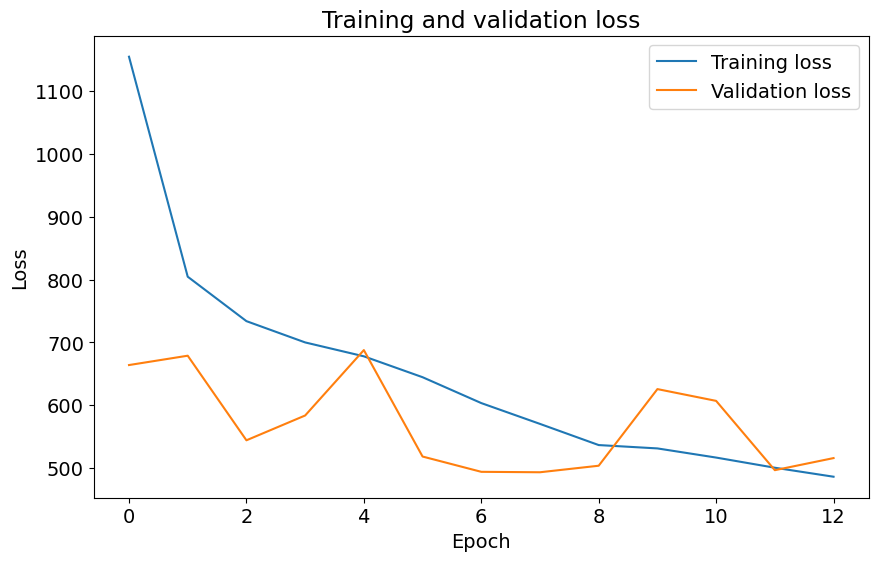

In [26]:
model12, mean_crps12, history12, predicted_means_std12 = process_model(model12, X_train=X_train_num, X_valid=X_valid_num, X_test=X_test_num, epochs = 200) 

In [27]:
model12a = build_baseline_model2(X_train_num.shape[1])

Mean CRPS for baseline model with all predictors (except one-hot encoded holiday data): 342.76, loss function v2 used


c:\Users\aisti\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model information:

Callbacks: EarlyStopping (patience: 5), Learning Rate (Reduce on Plateau, patience: 5)
Batch size: 10
Epochs: 200

Epoch 1/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 1886.9628 - val_loss: 587.9532 - learning_rate: 0.0010
Epoch 2/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 737.2772 - val_loss: 539.4651 - learning_rate: 0.0010
Epoch 3/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 713.5156 - val_loss: 596.5806 - learning_rate: 0.0010
Epoch 4/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 685.2338 - val_loss: 557.9813 - learning_rate: 0.0010
Epoch 5/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 650.4329 - val_loss: 550.1825 - learning_rate: 0.0010
Epoch 6/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 616.1404 - val_loss: 488.2529 - learning_rate: 0.0010
Epoch 7/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 570.2781 - val_loss: 614.6038 - learning_rate: 0.0010
Epoch 8/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss

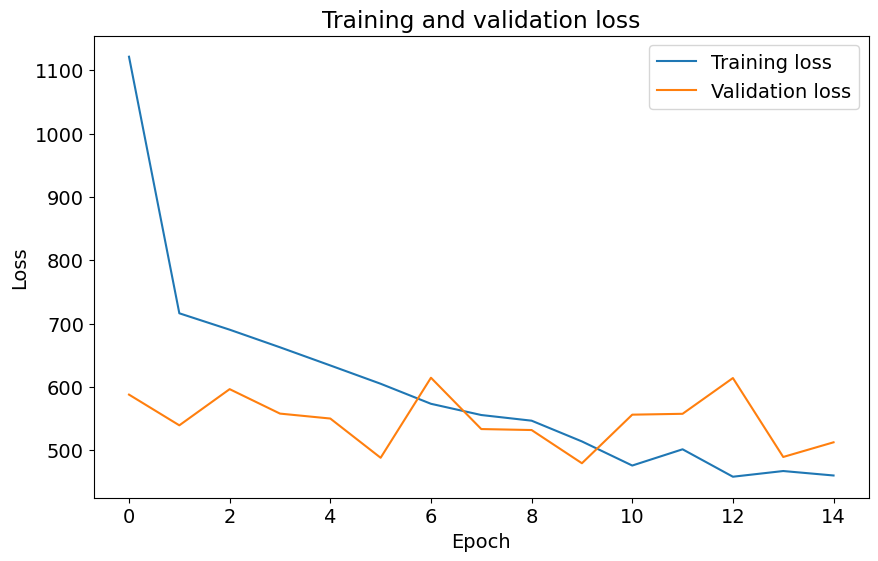

In [28]:
model12a, mean_crps12a, history12a, predicted_means_std12a = process_model(model12a, X_train=X_train_num, X_valid=X_valid_num, X_test=X_test_num, loss_function=crps_normal_cost_function_v2, epochs = 200)

Year doesn't seem to help

In [29]:
X_train_num = X_train_num.drop(columns=['year'])
X_valid_num = X_valid_num.drop(columns=['year'])
X_test_num = X_test_num.drop(columns=['year'])

### Adding a column for the month

In [30]:
X_train_num['month'] = X_train['month']
X_valid_num['month'] = X_valid['month']
X_test_num['month'] = X_test['month']

In [31]:
X_test_num.head()

,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,school_holiday_indicator,public_holiday_indicator,holiday_indicator,is_workday,season,day_of_week,month
0,0.156666,-0.574689,-0.146301,0.435186,1.740197,-0.397192,-0.385820,0.154228,0,1,1,1,0,3,6,1
1,-0.267002,0.406656,-0.196261,0.386631,1.259373,0.014675,-0.736694,0.819042,1,1,0,1,1,3,0,1
2,-0.832871,1.040183,-1.011237,0.313798,0.940566,-0.397192,0.160386,-0.996413,0,1,0,1,1,3,1,1
3,-0.452449,0.216184,3.104234,0.726518,1.005769,-0.319967,-1.094803,1.995252,1,1,0,1,1,3,2,1
4,-0.179777,0.572284,1.486773,0.807444,0.600781,-0.319967,-1.015223,1.253728,1,1,0,1,1,3,3,1


In [32]:
X_train_num, X_valid_num, X_test_num = normalize(X_train_num, X_valid_num, X_test_num, 'month')

In [33]:
X_train_num

,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,school_holiday_indicator,public_holiday_indicator,holiday_indicator,is_workday,season,day_of_week,month
0,-0.039776,-0.645081,-0.218119,0.079113,1.461434,-0.397192,-0.031329,0.665623,0,0,0,0,1,0,2,-0.781956
1,0.244625,-0.607815,-0.324284,1.042128,1.392951,-0.397192,-0.458165,0.154228,0,0,0,0,1,0,3,-0.781956
2,0.381694,-0.417343,-1.076810,0.831722,0.906360,-0.371451,0.254435,-1.124262,1,0,0,0,1,0,4,-0.781956
3,1.300863,-1.551894,-0.405469,-0.349793,0.675680,-0.397192,1.357699,-0.357168,0,0,0,0,0,0,5,-0.781956
4,0.745990,-0.897664,0.297096,0.532297,1.407369,0.555250,0.059103,1.688415,1,0,0,0,0,0,6,-0.781956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3156,-0.335171,0.737912,1.546101,0.564667,0.519395,2.872001,-1.094803,2.915764,1,1,0,1,1,3,1,1.557898
3157,-0.389412,1.284484,1.183889,0.807444,0.235983,0.297833,-1.094803,0.972461,1,1,0,1,1,3,2,1.557898
3158,0.183053,1.135419,1.211992,0.734611,1.887147,-0.319967,-1.087569,0.435495,1,1,0,1,1,3,3,1.557898
3159,-0.530879,1.574333,-0.599065,0.548482,-0.621426,-0.397192,-0.190488,-0.331598,0,1,0,1,1,3,4,1.557898


In [34]:
model13 = build_baseline_model(X_train_num.shape[1])


    Mean CRPS for baseline model with all predictors (except one-hot encoded holiday data): 397.22
    Columns in baseline model:
    'temperature', 'humidity', 'windspeed', 'wind_direction', 'visibility',
    'precipitation', 'sun', 'windspeed_max', 'precip_indic',
    'school_holiday_indicator', 'public_holiday_indicator',
    'holiday_indicator', 'is_workday', 'season', 'day_of_week'
    


c:\Users\aisti\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model information:

Callbacks: EarlyStopping (patience: 5), Learning Rate (Reduce on Plateau, patience: 5)
Batch size: 10
Epochs: 200

Epoch 1/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 1830.7439 - val_loss: 508.6771 - learning_rate: 0.0010
Epoch 2/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 790.1355 - val_loss: 522.1445 - learning_rate: 0.0010
Epoch 3/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 784.5646 - val_loss: 563.5981 - learning_rate: 0.0010
Epoch 4/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 705.2911 - val_loss: 467.6936 - learning_rate: 0.0010
Epoch 5/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 654.3268 - val_loss: 506.2183 - learning_rate: 0.0010
Epoch 6/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 644.2481 - val_loss: 490.6144 - learning_rate: 0.0010
Epoch 7/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 600.9526 - val_loss: 458.7386 - learning_rate: 0.0010
Epoch 8/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - 

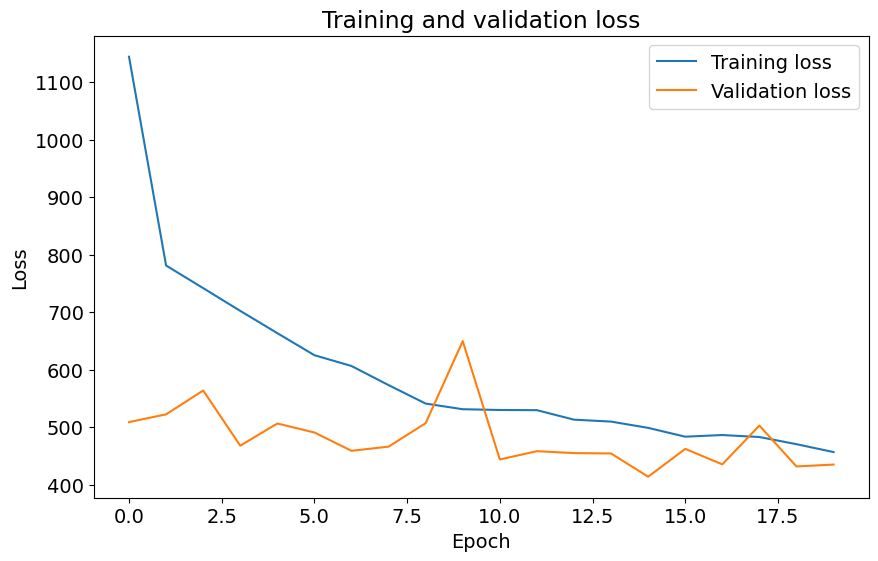

In [35]:
model13, mean_crps13, history13, predicted_means_std13 = process_model(model13, X_train=X_train_num, X_valid=X_valid_num, X_test=X_test_num, epochs = 200)

In [36]:
model13a = build_baseline_model2(X_train_num.shape[1])

Mean CRPS for baseline model with all predictors (except one-hot encoded holiday data): 342.76, loss function v2 used


c:\Users\aisti\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model information:

Callbacks: EarlyStopping (patience: 5), Learning Rate (Reduce on Plateau, patience: 5)
Batch size: 10
Epochs: 200

Epoch 1/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 1898.8486 - val_loss: 533.9556 - learning_rate: 0.0010
Epoch 2/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 732.2568 - val_loss: 572.1601 - learning_rate: 0.0010
Epoch 3/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 703.9938 - val_loss: 601.3091 - learning_rate: 0.0010
Epoch 4/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 668.7279 - val_loss: 591.9933 - learning_rate: 0.0010
Epoch 5/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 630.8242 - val_loss: 513.5538 - learning_rate: 0.0010
Epoch 6/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 625.0159 - val_loss: 486.6654 - learning_rate: 0.0010
Epoch 7/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 608.8309 - val_loss: 495.7960 - learning_rate: 0.0010
Epoch 8/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - los

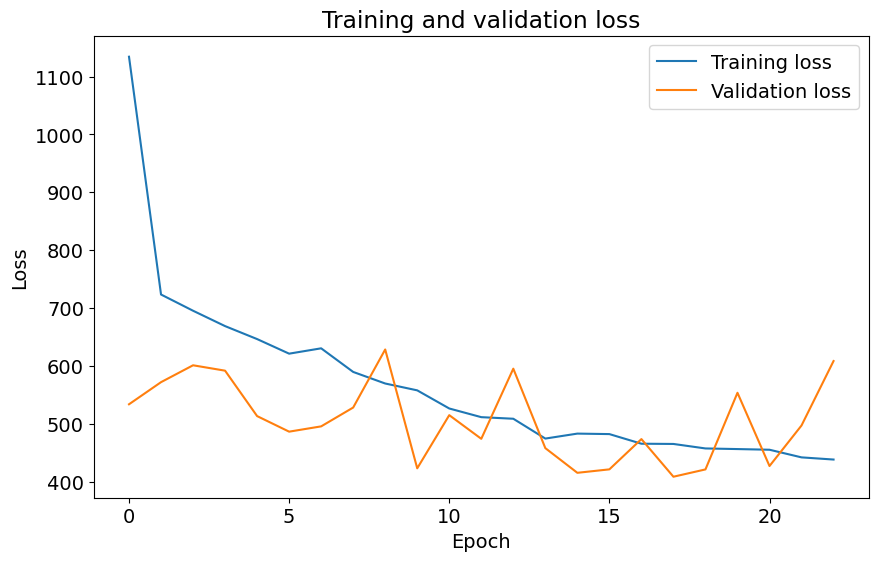

In [37]:
model13a, mean_crps13a, history13a, predicted_means_std13a = process_model(model13a, X_train=X_train_num, X_valid=X_valid_num, X_test=X_test_num, loss_function=crps_normal_cost_function_v2, epochs = 200)

month doesnt seem to be helpful either

In [38]:
X_train_num = X_train_num.drop(columns=['month'])
X_valid_num = X_valid_num.drop(columns=['month'])
X_test_num = X_test_num.drop(columns=['month'])

In [39]:
X_train = X_train.drop(columns=['year', 'month'])
X_valid = X_valid.drop(columns=['year', 'month'])
X_test = X_test.drop(columns=['year', 'month'])

In [40]:
X_train.head()

,date,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,school_holiday,school_holiday_indicator,public_holiday,public_holiday_indicator,holiday_indicator,is_workday,season,day_of_week
0,2012-04-25,-0.039776,-0.645081,-0.218119,0.079113,1.461434,-0.397192,-0.031329,0.665623,0,No Holiday,0,No Holiday,0,0,1,0,2
1,2012-04-26,0.244625,-0.607815,-0.324284,1.042128,1.392951,-0.397192,-0.458165,0.154228,0,No Holiday,0,No Holiday,0,0,1,0,3
2,2012-04-27,0.381694,-0.417343,-1.076810,0.831722,0.906360,-0.371451,0.254435,-1.124262,1,No Holiday,0,No Holiday,0,0,1,0,4
3,2012-04-28,1.300863,-1.551894,-0.405469,-0.349793,0.675680,-0.397192,1.357699,-0.357168,0,No Holiday,0,No Holiday,0,0,0,0,5
4,2012-04-29,0.745990,-0.897664,0.297096,0.532297,1.407369,0.555250,0.059103,1.688415,1,No Holiday,0,No Holiday,0,0,0,0,6


## Dropping Columns

### Dropping the temperature column

In [41]:
# Drop the 'temperature' column from X_train_num, X_valid_num, and X_test_num
X_train_num = X_train_num.drop(columns=['temperature'])
X_valid_num = X_valid_num.drop(columns=['temperature'])
X_test_num = X_test_num.drop(columns=['temperature'])

In [42]:
X_train_num.head()

,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,school_holiday_indicator,public_holiday_indicator,holiday_indicator,is_workday,season,day_of_week
0,-0.645081,-0.218119,0.079113,1.461434,-0.397192,-0.031329,0.665623,0,0,0,0,1,0,2
1,-0.607815,-0.324284,1.042128,1.392951,-0.397192,-0.458165,0.154228,0,0,0,0,1,0,3
2,-0.417343,-1.076810,0.831722,0.906360,-0.371451,0.254435,-1.124262,1,0,0,0,1,0,4
3,-1.551894,-0.405469,-0.349793,0.675680,-0.397192,1.357699,-0.357168,0,0,0,0,0,0,5
4,-0.897664,0.297096,0.532297,1.407369,0.555250,0.059103,1.688415,1,0,0,0,0,0,6


In [43]:
X_train_num.shape, X_valid_num.shape, X_test_num.shape

((3161, 14), (364, 14), (390, 14))

In [44]:
model14 = build_baseline_model(X_train_num.shape[1])


    Mean CRPS for baseline model with all predictors (except one-hot encoded holiday data): 397.22
    Columns in baseline model:
    'temperature', 'humidity', 'windspeed', 'wind_direction', 'visibility',
    'precipitation', 'sun', 'windspeed_max', 'precip_indic',
    'school_holiday_indicator', 'public_holiday_indicator',
    'holiday_indicator', 'is_workday', 'season', 'day_of_week'
    


c:\Users\aisti\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model information:

Callbacks: EarlyStopping (patience: 5), Learning Rate (Reduce on Plateau, patience: 5)
Batch size: 10
Epochs: 200

Epoch 1/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 2008.4188 - val_loss: 586.4899 - learning_rate: 0.0010
Epoch 2/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 886.6752 - val_loss: 562.1555 - learning_rate: 0.0010
Epoch 3/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 775.8837 - val_loss: 615.1888 - learning_rate: 0.0010
Epoch 4/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 757.7501 - val_loss: 592.9331 - learning_rate: 0.0010
Epoch 5/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 707.6235 - val_loss: 525.1153 - learning_rate: 0.0010
Epoch 6/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 701.7291 - val_loss: 620.0823 - learning_rate: 0.0010
Epoch 7/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 662.0453 - val_loss: 651.4274 - learning_rate: 0.0010
Epoch 8/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - l

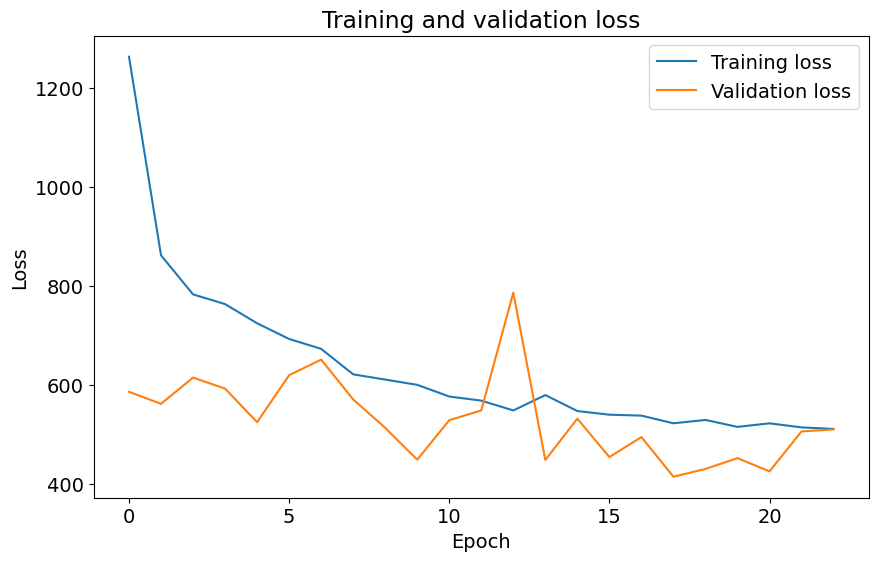

In [45]:
model14, mean_crps14, history14, predicted_means_std14 = process_model(model14, X_train=X_train_num, X_valid=X_valid_num, X_test=X_test_num, epochs = 200) 

In [46]:
model14a = build_baseline_model2(X_train_num.shape[1])

Mean CRPS for baseline model with all predictors (except one-hot encoded holiday data): 342.76, loss function v2 used


c:\Users\aisti\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model information:

Callbacks: EarlyStopping (patience: 5), Learning Rate (Reduce on Plateau, patience: 5)
Batch size: 10
Epochs: 200

Epoch 1/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 13s 12ms/step - loss: 1942.5552 - val_loss: 608.6349 - learning_rate: 0.0010
Epoch 2/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 829.8369 - val_loss: 574.6636 - learning_rate: 0.0010
Epoch 3/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 741.4901 - val_loss: 548.1367 - learning_rate: 0.0010
Epoch 4/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 712.4849 - val_loss: 664.4957 - learning_rate: 0.0010
Epoch 5/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 712.2422 - val_loss: 511.8236 - learning_rate: 0.0010
Epoch 6/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 649.1852 - val_loss: 568.5945 - learning_rate: 0.0010
Epoch 7/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 645.7892 - val_loss: 528.6735 - learning_rate: 0.0010
Epoch 8/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - 

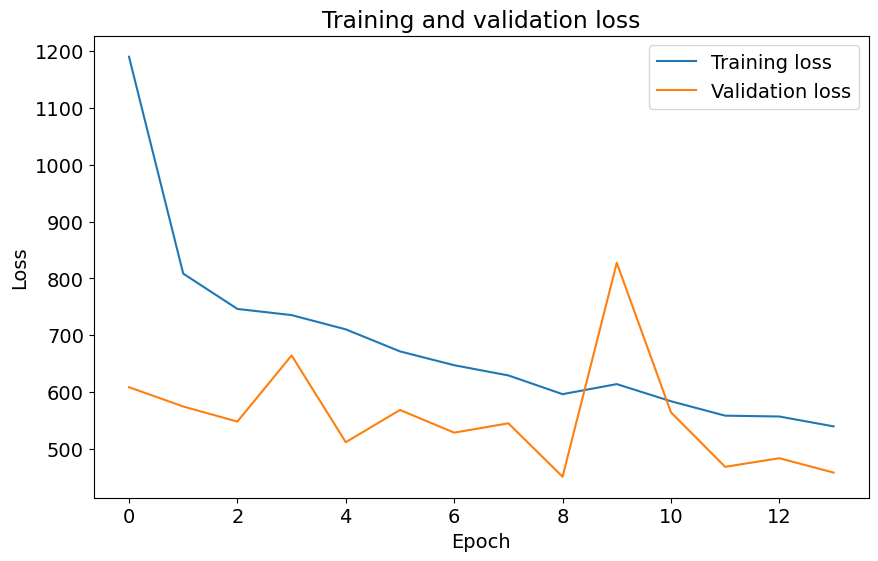

In [47]:
model14a, mean_crps14a, history14a, predicted_means_std14a = process_model(model14a, X_train=X_train_num, X_valid=X_valid_num, X_test=X_test_num, epochs = 200, loss_function=crps_normal_cost_function_v2)

In [48]:
X_train_num['temperature'] = X_train['temperature']
X_valid_num['temperature'] = X_valid['temperature']
X_test_num['temperature'] = X_test['temperature']

### Dropping the humidity column

In [49]:
X_train_num = X_train_num.drop(columns=['humidity'])
X_valid_num = X_valid_num.drop(columns=['humidity'])
X_test_num = X_test_num.drop(columns=['humidity'])

In [50]:
X_train_num.head()

,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,school_holiday_indicator,public_holiday_indicator,holiday_indicator,is_workday,season,day_of_week,temperature
0,-0.218119,0.079113,1.461434,-0.397192,-0.031329,0.665623,0,0,0,0,1,0,2,-0.039776
1,-0.324284,1.042128,1.392951,-0.397192,-0.458165,0.154228,0,0,0,0,1,0,3,0.244625
2,-1.076810,0.831722,0.906360,-0.371451,0.254435,-1.124262,1,0,0,0,1,0,4,0.381694
3,-0.405469,-0.349793,0.675680,-0.397192,1.357699,-0.357168,0,0,0,0,0,0,5,1.300863
4,0.297096,0.532297,1.407369,0.555250,0.059103,1.688415,1,0,0,0,0,0,6,0.745990


In [51]:
X_valid_num.shape

(364, 14)

In [52]:
model15 = build_baseline_model(X_train_num.shape[1])

c:\Users\aisti\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



    Mean CRPS for baseline model with all predictors (except one-hot encoded holiday data): 397.22
    Columns in baseline model:
    'temperature', 'humidity', 'windspeed', 'wind_direction', 'visibility',
    'precipitation', 'sun', 'windspeed_max', 'precip_indic',
    'school_holiday_indicator', 'public_holiday_indicator',
    'holiday_indicator', 'is_workday', 'season', 'day_of_week'
    


Model information:

Callbacks: EarlyStopping (patience: 5), Learning Rate (Reduce on Plateau, patience: 5)
Batch size: 10
Epochs: 200

Epoch 1/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - loss: 1851.7848 - val_loss: 698.0370 - learning_rate: 0.0010
Epoch 2/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 792.0895 - val_loss: 551.5897 - learning_rate: 0.0010
Epoch 3/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 767.7908 - val_loss: 495.4017 - learning_rate: 0.0010
Epoch 4/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 691.7382 - val_loss: 531.6518 - learning_rate: 0.0010
Epoch 5/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 666.4444 - val_loss: 561.0092 - learning_rate: 0.0010
Epoch 6/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 639.3218 - val_loss: 458.1746 - learning_rate: 0.0010
Epoch 7/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 614.4794 - val_loss: 459.7188 - learning_rate: 0.0010
Epoch 8/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - l

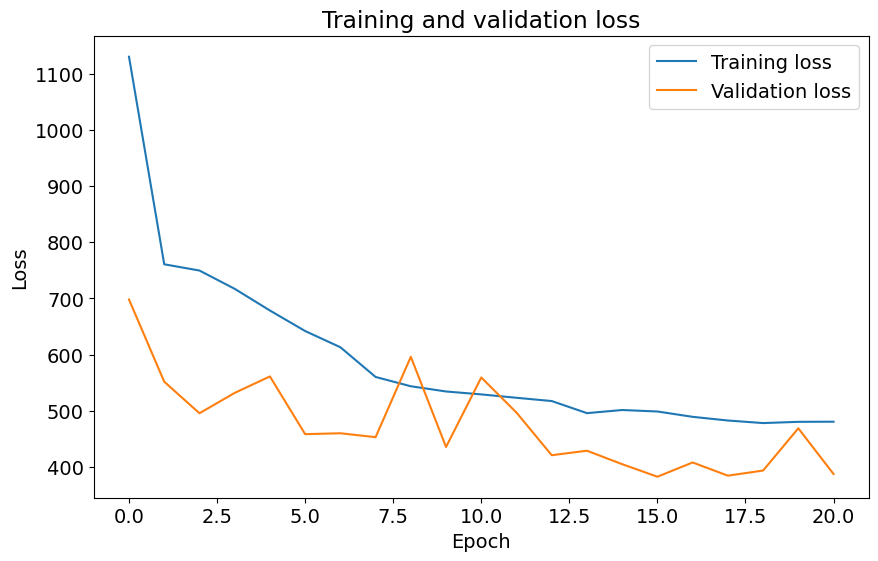

In [53]:
model15, mean_crps15, history15, predicted_means_std15 = process_model(model15, X_train=X_train_num, X_valid=X_valid_num, X_test=X_test_num, epochs = 200) 

In [54]:
model16 = build_baseline_model2(X_train_num.shape[1])

Mean CRPS for baseline model with all predictors (except one-hot encoded holiday data): 342.76, loss function v2 used


c:\Users\aisti\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model information:

Callbacks: EarlyStopping (patience: 5), Learning Rate (Reduce on Plateau, patience: 5)
Batch size: 10
Epochs: 200

Epoch 1/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 1897.4358 - val_loss: 631.6290 - learning_rate: 0.0010
Epoch 2/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 724.1380 - val_loss: 655.7770 - learning_rate: 0.0010
Epoch 3/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 702.9861 - val_loss: 502.9390 - learning_rate: 0.0010
Epoch 4/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 697.2129 - val_loss: 620.7186 - learning_rate: 0.0010
Epoch 5/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 637.1905 - val_loss: 563.9890 - learning_rate: 0.0010
Epoch 6/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 645.1735 - val_loss: 488.8541 - learning_rate: 0.0010
Epoch 7/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 599.5999 - val_loss: 451.5842 - learning_rate: 0.0010
Epoch 8/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss

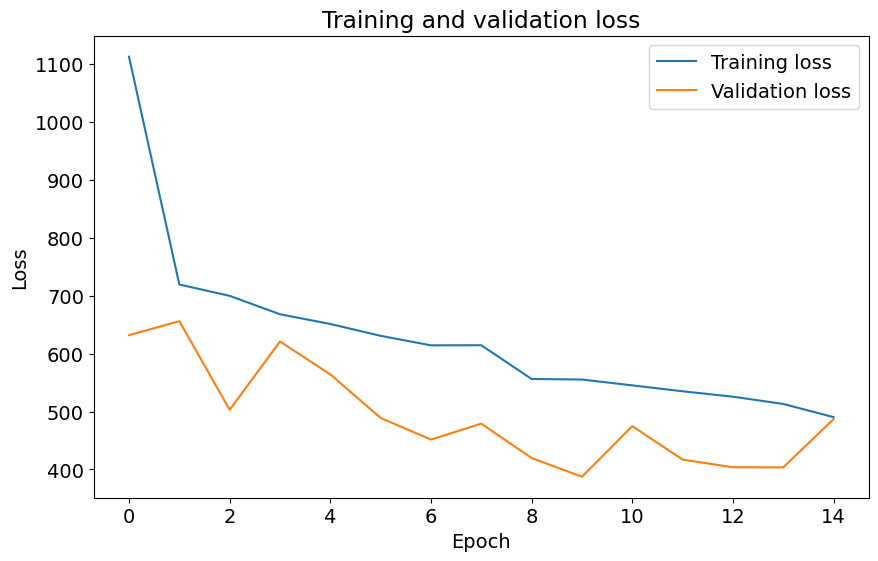

In [55]:
model16, mean_crps16, history16, predicted_means_std16 = process_model(model16, X_train=X_train_num, X_valid=X_valid_num, X_test=X_test_num, epochs = 200, loss_function=crps_normal_cost_function_v2)

In [56]:
X_train_num.head()

,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,school_holiday_indicator,public_holiday_indicator,holiday_indicator,is_workday,season,day_of_week,temperature
0,-0.218119,0.079113,1.461434,-0.397192,-0.031329,0.665623,0,0,0,0,1,0,2,-0.039776
1,-0.324284,1.042128,1.392951,-0.397192,-0.458165,0.154228,0,0,0,0,1,0,3,0.244625
2,-1.076810,0.831722,0.906360,-0.371451,0.254435,-1.124262,1,0,0,0,1,0,4,0.381694
3,-0.405469,-0.349793,0.675680,-0.397192,1.357699,-0.357168,0,0,0,0,0,0,5,1.300863
4,0.297096,0.532297,1.407369,0.555250,0.059103,1.688415,1,0,0,0,0,0,6,0.745990


In [57]:
X_train_num['humidity'] = X_train['humidity']
X_valid_num['humidity'] = X_valid['humidity']
X_test_num['humidity'] = X_test['humidity']

### Dropping the wind speed column

In [58]:
# Drop the 'windspeed' column from X_train_num, X_valid_num, and X_test_num
X_train_num = X_train_num.drop(columns=['windspeed'])
X_valid_num = X_valid_num.drop(columns=['windspeed'])
X_test_num = X_test_num.drop(columns=['windspeed'])

In [59]:
model17 = build_baseline_model(X_train_num.shape[1])


    Mean CRPS for baseline model with all predictors (except one-hot encoded holiday data): 397.22
    Columns in baseline model:
    'temperature', 'humidity', 'windspeed', 'wind_direction', 'visibility',
    'precipitation', 'sun', 'windspeed_max', 'precip_indic',
    'school_holiday_indicator', 'public_holiday_indicator',
    'holiday_indicator', 'is_workday', 'season', 'day_of_week'
    


c:\Users\aisti\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model information:

Callbacks: EarlyStopping (patience: 5), Learning Rate (Reduce on Plateau, patience: 5)
Batch size: 10
Epochs: 200

Epoch 1/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 1891.6248 - val_loss: 572.3574 - learning_rate: 0.0010
Epoch 2/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 777.7626 - val_loss: 651.4742 - learning_rate: 0.0010
Epoch 3/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 792.8464 - val_loss: 554.4424 - learning_rate: 0.0010
Epoch 4/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 695.7499 - val_loss: 623.8077 - learning_rate: 0.0010
Epoch 5/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 768.2413 - val_loss: 534.3611 - learning_rate: 0.0010
Epoch 6/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 660.9965 - val_loss: 498.7642 - learning_rate: 0.0010
Epoch 7/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 635.7719 - val_loss: 483.0109 - learning_rate: 0.0010
Epoch 8/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - 

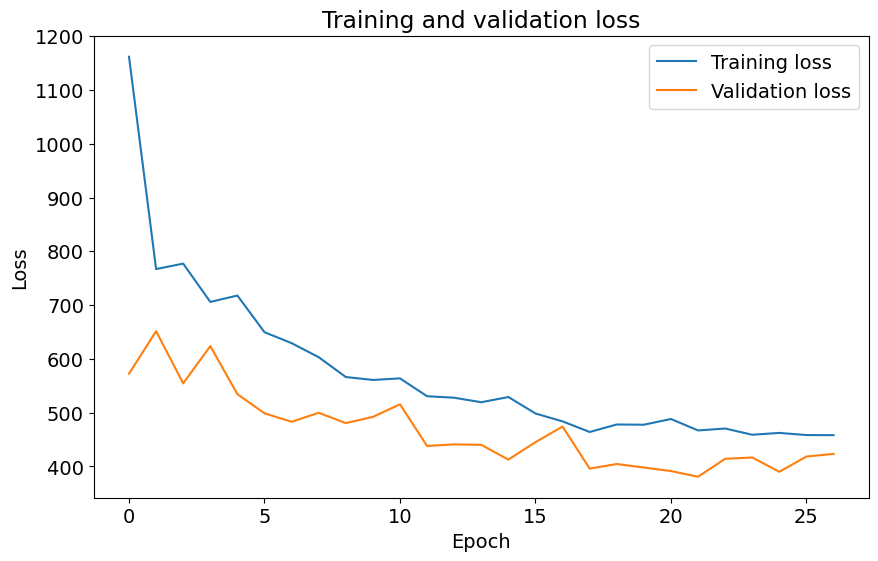

In [60]:
model17, mean_crps17, history17, predicted_means_std17 = process_model(model17, X_train=X_train_num, X_valid=X_valid_num, X_test=X_test_num, epochs = 200) 

In [61]:
model18 = build_baseline_model2(X_train_num.shape[1])

Mean CRPS for baseline model with all predictors (except one-hot encoded holiday data): 342.76, loss function v2 used


c:\Users\aisti\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model information:

Callbacks: EarlyStopping (patience: 5), Learning Rate (Reduce on Plateau, patience: 5)
Batch size: 10
Epochs: 200

Epoch 1/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 1881.7668 - val_loss: 527.3441 - learning_rate: 0.0010
Epoch 2/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 725.3151 - val_loss: 536.6888 - learning_rate: 0.0010
Epoch 3/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 689.5999 - val_loss: 512.5972 - learning_rate: 0.0010
Epoch 4/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 720.9807 - val_loss: 529.5992 - learning_rate: 0.0010
Epoch 5/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 633.3386 - val_loss: 567.2159 - learning_rate: 0.0010
Epoch 6/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 639.0836 - val_loss: 531.3264 - learning_rate: 0.0010
Epoch 7/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 582.0450 - val_loss: 534.6867 - learning_rate: 0.0010
Epoch 8/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss

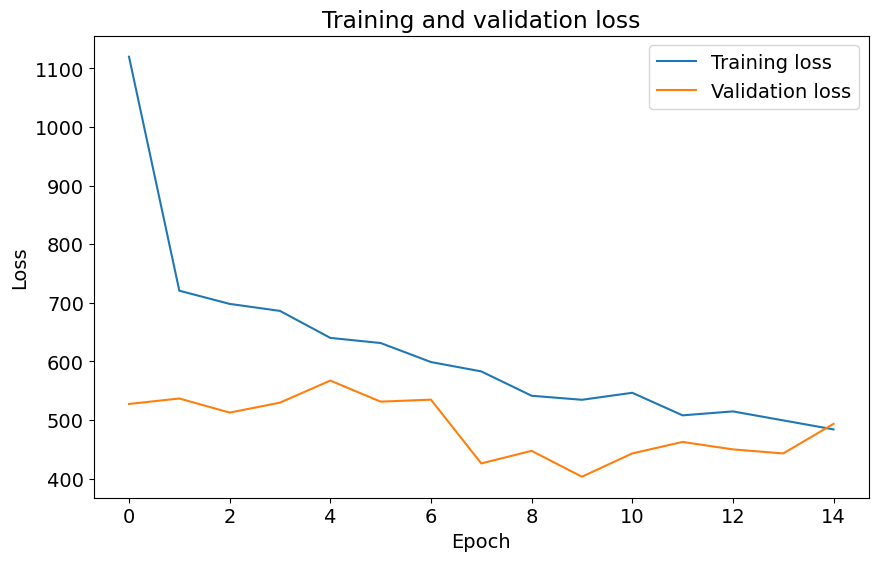

In [62]:
model18, mean_crps18, history18, predicted_means_std18 = process_model(model18, X_train=X_train_num, X_valid=X_valid_num, X_test=X_test_num, epochs = 200, loss_function=crps_normal_cost_function_v2)


In [63]:
X_train_num['windspeed'] = X_train['windspeed']
X_valid_num['windspeed'] = X_valid['windspeed']
X_test_num['windspeed'] = X_test['windspeed']

In [64]:
X_train_num.head()

,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,school_holiday_indicator,public_holiday_indicator,holiday_indicator,is_workday,season,day_of_week,temperature,humidity,windspeed
0,0.079113,1.461434,-0.397192,-0.031329,0.665623,0,0,0,0,1,0,2,-0.039776,-0.645081,-0.218119
1,1.042128,1.392951,-0.397192,-0.458165,0.154228,0,0,0,0,1,0,3,0.244625,-0.607815,-0.324284
2,0.831722,0.906360,-0.371451,0.254435,-1.124262,1,0,0,0,1,0,4,0.381694,-0.417343,-1.076810
3,-0.349793,0.675680,-0.397192,1.357699,-0.357168,0,0,0,0,0,0,5,1.300863,-1.551894,-0.405469
4,0.532297,1.407369,0.555250,0.059103,1.688415,1,0,0,0,0,0,6,0.745990,-0.897664,0.297096


### Dropping the wind direction column

In [65]:
X_train_num = X_train_num.drop(columns=['wind_direction'])
X_valid_num = X_valid_num.drop(columns=['wind_direction'])
X_test_num = X_test_num.drop(columns=['wind_direction'])

In [66]:
model19 = build_baseline_model(X_train_num.shape[1])


    Mean CRPS for baseline model with all predictors (except one-hot encoded holiday data): 397.22
    Columns in baseline model:
    'temperature', 'humidity', 'windspeed', 'wind_direction', 'visibility',
    'precipitation', 'sun', 'windspeed_max', 'precip_indic',
    'school_holiday_indicator', 'public_holiday_indicator',
    'holiday_indicator', 'is_workday', 'season', 'day_of_week'
    


c:\Users\aisti\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model information:

Callbacks: EarlyStopping (patience: 5), Learning Rate (Reduce on Plateau, patience: 5)
Batch size: 10
Epochs: 200

Epoch 1/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 1843.8137 - val_loss: 560.9327 - learning_rate: 0.0010
Epoch 2/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 792.1182 - val_loss: 505.5002 - learning_rate: 0.0010
Epoch 3/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 720.0092 - val_loss: 789.7482 - learning_rate: 0.0010
Epoch 4/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 749.1451 - val_loss: 515.0778 - learning_rate: 0.0010
Epoch 5/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 682.8577 - val_loss: 531.0561 - learning_rate: 0.0010
Epoch 6/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 646.3544 - val_loss: 551.2960 - learning_rate: 0.0010
Epoch 7/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 625.0538 - val_loss: 479.6834 - learning_rate: 0.0010
Epoch 8/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss

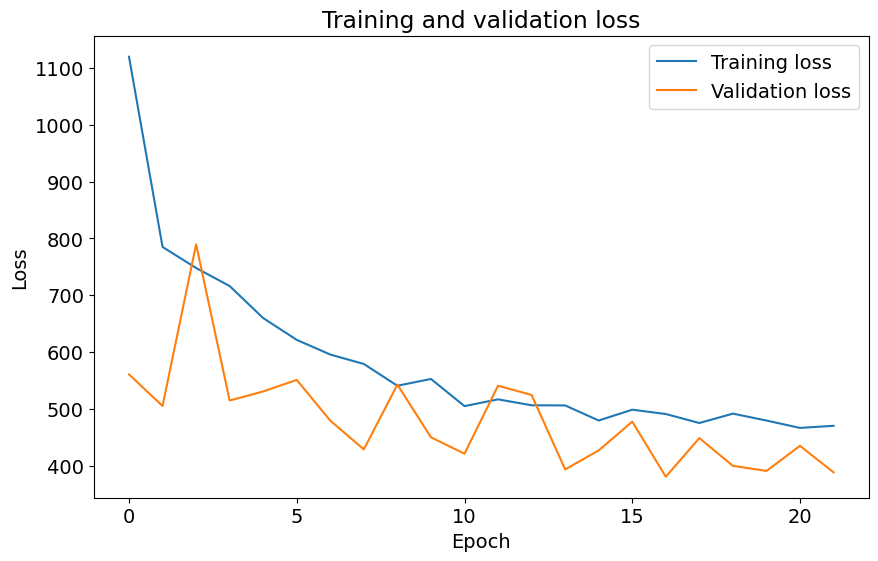

In [67]:
model19, mean_crps19, history19, predicted_means_std19 = process_model(model19, X_train=X_train_num, X_valid=X_valid_num, X_test=X_test_num, epochs = 200)

In [68]:
model20 = build_baseline_model2(X_train_num.shape[1])

Mean CRPS for baseline model with all predictors (except one-hot encoded holiday data): 342.76, loss function v2 used


c:\Users\aisti\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model information:

Callbacks: EarlyStopping (patience: 5), Learning Rate (Reduce on Plateau, patience: 5)
Batch size: 10
Epochs: 200

Epoch 1/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 1925.9869 - val_loss: 585.5964 - learning_rate: 0.0010
Epoch 2/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 769.3751 - val_loss: 543.8780 - learning_rate: 0.0010
Epoch 3/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 722.3281 - val_loss: 494.7749 - learning_rate: 0.0010
Epoch 4/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 657.1426 - val_loss: 491.9545 - learning_rate: 0.0010
Epoch 5/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 658.7584 - val_loss: 516.2784 - learning_rate: 0.0010
Epoch 6/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 627.8846 - val_loss: 522.4415 - learning_rate: 0.0010
Epoch 7/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 617.8257 - val_loss: 511.8914 - learning_rate: 0.0010
Epoch 8/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss

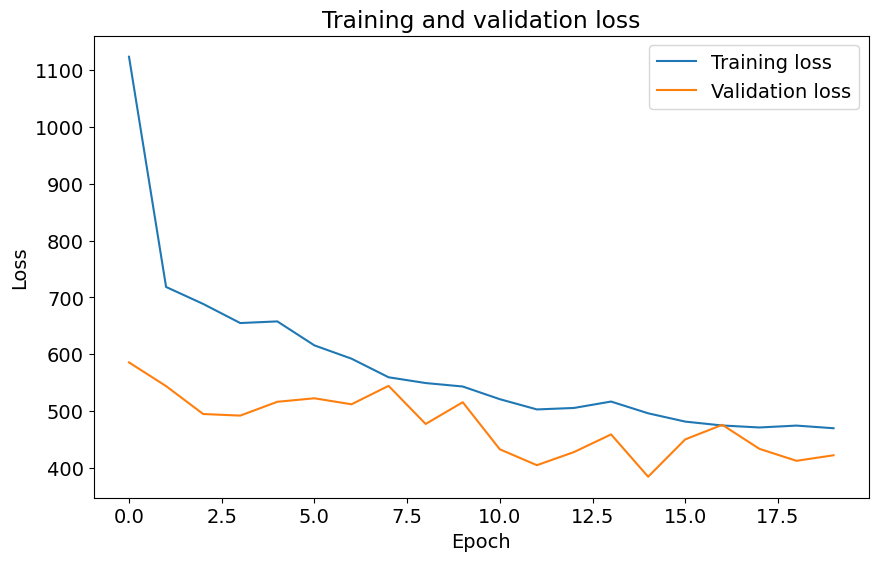

In [69]:
model20, mean_crps20, history20, predicted_means_std20 = process_model(model20, X_train=X_train_num, X_valid=X_valid_num, X_test=X_test_num, epochs = 200, loss_function=crps_normal_cost_function_v2)

In [70]:
X_train_num, X_valid_num, X_test_num = add_column(X_train_num, X_valid_num, X_test_num, X_train, X_valid, X_test, 'wind_direction')

### Dropping the visibility column

In [71]:
X_train_num = X_train_num.drop(columns=['visibility'])
X_valid_num = X_valid_num.drop(columns=['visibility'])
X_test_num = X_test_num.drop(columns=['visibility'])

In [72]:
X_train_num.head()

,precipitation,sun,windspeed_max,precip_indic,school_holiday_indicator,public_holiday_indicator,holiday_indicator,is_workday,season,day_of_week,temperature,humidity,windspeed,wind_direction
0,-0.397192,-0.031329,0.665623,0,0,0,0,1,0,2,-0.039776,-0.645081,-0.218119,0.079113
1,-0.397192,-0.458165,0.154228,0,0,0,0,1,0,3,0.244625,-0.607815,-0.324284,1.042128
2,-0.371451,0.254435,-1.124262,1,0,0,0,1,0,4,0.381694,-0.417343,-1.076810,0.831722
3,-0.397192,1.357699,-0.357168,0,0,0,0,0,0,5,1.300863,-1.551894,-0.405469,-0.349793
4,0.555250,0.059103,1.688415,1,0,0,0,0,0,6,0.745990,-0.897664,0.297096,0.532297


In [73]:
model21 = build_baseline_model(X_train_num.shape[1])

c:\Users\aisti\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



    Mean CRPS for baseline model with all predictors (except one-hot encoded holiday data): 397.22
    Columns in baseline model:
    'temperature', 'humidity', 'windspeed', 'wind_direction', 'visibility',
    'precipitation', 'sun', 'windspeed_max', 'precip_indic',
    'school_holiday_indicator', 'public_holiday_indicator',
    'holiday_indicator', 'is_workday', 'season', 'day_of_week'
    


Model information:

Callbacks: EarlyStopping (patience: 5), Learning Rate (Reduce on Plateau, patience: 5)
Batch size: 10
Epochs: 200

Epoch 1/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 1931.9050 - val_loss: 641.3024 - learning_rate: 0.0010
Epoch 2/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 789.5610 - val_loss: 510.2373 - learning_rate: 0.0010
Epoch 3/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 788.9389 - val_loss: 574.8215 - learning_rate: 0.0010
Epoch 4/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 701.0746 - val_loss: 621.5740 - learning_rate: 0.0010
Epoch 5/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 706.4755 - val_loss: 469.4323 - learning_rate: 0.0010
Epoch 6/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 659.9534 - val_loss: 584.3690 - learning_rate: 0.0010
Epoch 7/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 645.6437 - val_loss: 472.9184 - learning_rate: 0.0010
Epoch 8/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - lo

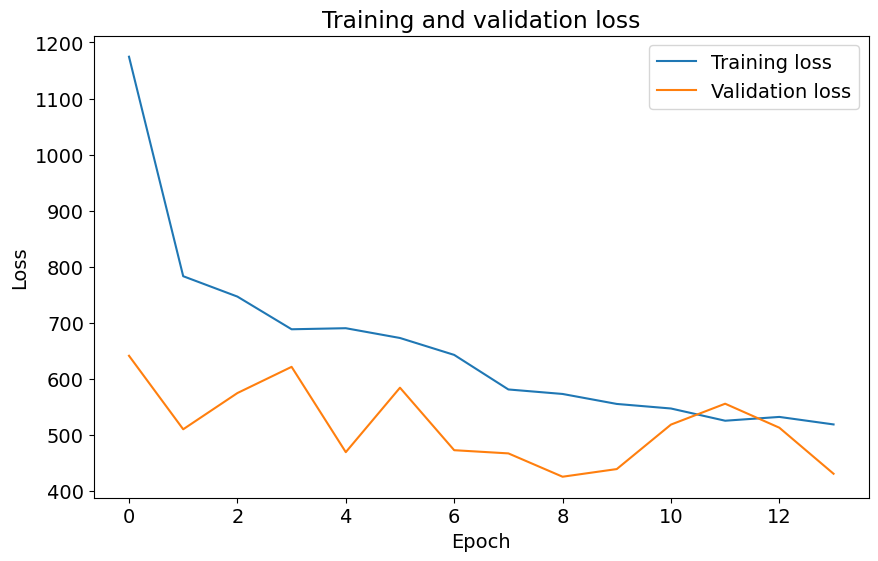

In [74]:
model21, mean_crps21, history21, predicted_means_std21 = process_model(model21, X_train=X_train_num, X_valid=X_valid_num, X_test=X_test_num, epochs = 200)

In [75]:
model22 = build_baseline_model2(X_train_num.shape[1])

Mean CRPS for baseline model with all predictors (except one-hot encoded holiday data): 342.76, loss function v2 used


c:\Users\aisti\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model information:

Callbacks: EarlyStopping (patience: 5), Learning Rate (Reduce on Plateau, patience: 5)
Batch size: 10
Epochs: 200

Epoch 1/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - loss: 1896.1586 - val_loss: 545.0275 - learning_rate: 0.0010
Epoch 2/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 735.6169 - val_loss: 554.3813 - learning_rate: 0.0010
Epoch 3/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 698.9748 - val_loss: 507.7289 - learning_rate: 0.0010
Epoch 4/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 676.8445 - val_loss: 590.0415 - learning_rate: 0.0010
Epoch 5/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 621.9255 - val_loss: 484.5068 - learning_rate: 0.0010
Epoch 6/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 662.2401 - val_loss: 561.3979 - learning_rate: 0.0010
Epoch 7/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 594.3307 - val_loss: 628.3703 - learning_rate: 0.0010
Epoch 8/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss

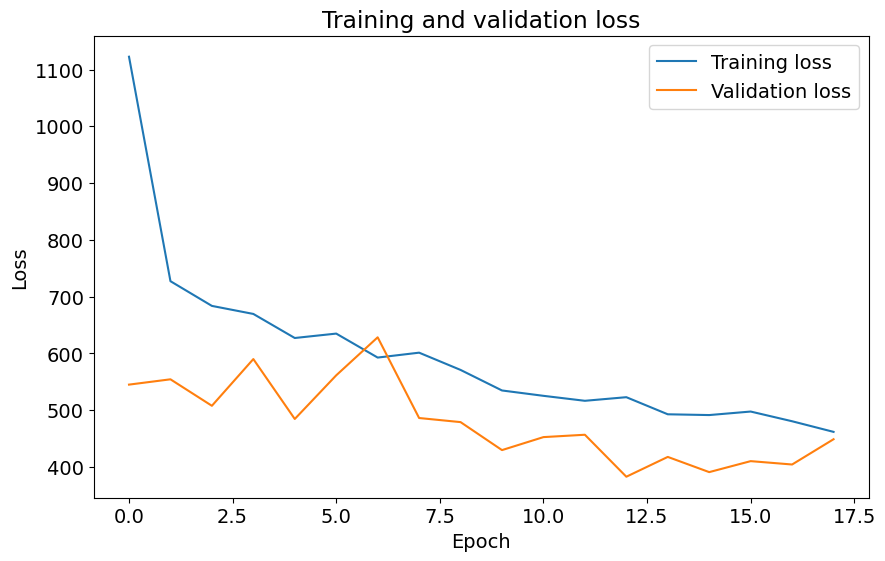

In [76]:
model22, mean_crps22, history22, predicted_means_std22 = process_model(model22, X_train=X_train_num, X_valid=X_valid_num, X_test=X_test_num, epochs = 200, loss_function=crps_normal_cost_function_v2)

In [77]:
X_train_num, X_valid_num, X_test_num = add_column(X_train_num, X_valid_num, X_test_num, X_train, X_valid, X_test, 'visibility')

In [78]:
X_train_num.head()

,precipitation,sun,windspeed_max,precip_indic,school_holiday_indicator,public_holiday_indicator,holiday_indicator,is_workday,season,day_of_week,temperature,humidity,windspeed,wind_direction,visibility
0,-0.397192,-0.031329,0.665623,0,0,0,0,1,0,2,-0.039776,-0.645081,-0.218119,0.079113,1.461434
1,-0.397192,-0.458165,0.154228,0,0,0,0,1,0,3,0.244625,-0.607815,-0.324284,1.042128,1.392951
2,-0.371451,0.254435,-1.124262,1,0,0,0,1,0,4,0.381694,-0.417343,-1.076810,0.831722,0.906360
3,-0.397192,1.357699,-0.357168,0,0,0,0,0,0,5,1.300863,-1.551894,-0.405469,-0.349793,0.675680
4,0.555250,0.059103,1.688415,1,0,0,0,0,0,6,0.745990,-0.897664,0.297096,0.532297,1.407369


### Dropping the precipitation column

In [79]:
X_train_num = X_train_num.drop(columns=['precipitation'])
X_valid_num = X_valid_num.drop(columns=['precipitation'])
X_test_num = X_test_num.drop(columns=['precipitation'])

In [80]:
model23 = build_baseline_model(X_train_num.shape[1])


    Mean CRPS for baseline model with all predictors (except one-hot encoded holiday data): 397.22
    Columns in baseline model:
    'temperature', 'humidity', 'windspeed', 'wind_direction', 'visibility',
    'precipitation', 'sun', 'windspeed_max', 'precip_indic',
    'school_holiday_indicator', 'public_holiday_indicator',
    'holiday_indicator', 'is_workday', 'season', 'day_of_week'
    


c:\Users\aisti\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model information:

Callbacks: EarlyStopping (patience: 5), Learning Rate (Reduce on Plateau, patience: 5)
Batch size: 10
Epochs: 200

Epoch 1/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 1878.0442 - val_loss: 632.9540 - learning_rate: 0.0010
Epoch 2/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 760.9467 - val_loss: 609.1851 - learning_rate: 0.0010
Epoch 3/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 777.8392 - val_loss: 597.2849 - learning_rate: 0.0010
Epoch 4/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 743.9622 - val_loss: 497.7434 - learning_rate: 0.0010
Epoch 5/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 684.9598 - val_loss: 495.4221 - learning_rate: 0.0010
Epoch 6/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 640.7947 - val_loss: 762.6398 - learning_rate: 0.0010
Epoch 7/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 663.5969 - val_loss: 465.1020 - learning_rate: 0.0010
Epoch 8/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss

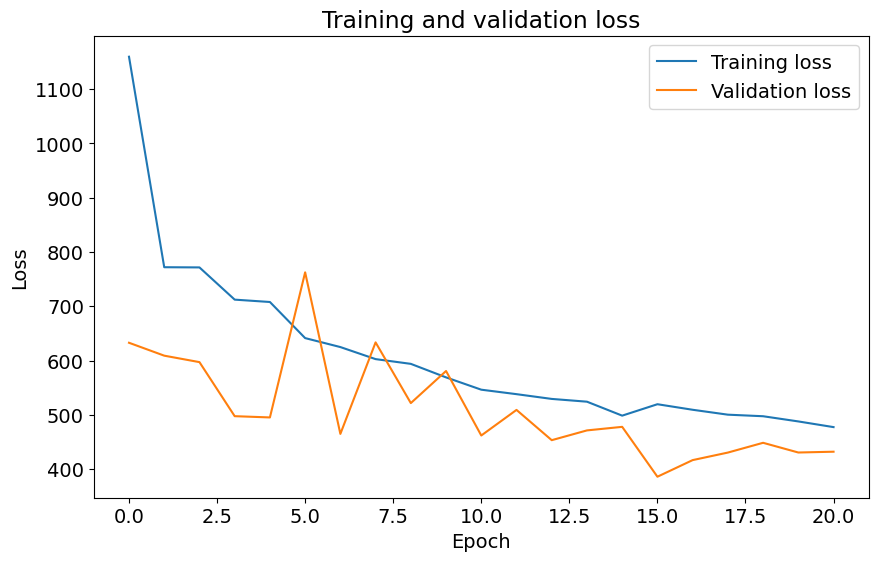

In [81]:
model23, mean_crps23, history23, predicted_means_std23 = process_model(model23, X_train=X_train_num, X_valid=X_valid_num, X_test=X_test_num, epochs = 200)

In [82]:
model23a = build_baseline_model2(X_train_num.shape[1])

Mean CRPS for baseline model with all predictors (except one-hot encoded holiday data): 342.76, loss function v2 used


c:\Users\aisti\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model information:

Callbacks: EarlyStopping (patience: 5), Learning Rate (Reduce on Plateau, patience: 5)
Batch size: 10
Epochs: 200

Epoch 1/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 9s 8ms/step - loss: 1911.1705 - val_loss: 550.4391 - learning_rate: 0.0010
Epoch 2/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 732.6268 - val_loss: 541.0269 - learning_rate: 0.0010
Epoch 3/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 702.0689 - val_loss: 549.1922 - learning_rate: 0.0010
Epoch 4/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 729.0511 - val_loss: 521.2772 - learning_rate: 0.0010
Epoch 5/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 679.6723 - val_loss: 520.1348 - learning_rate: 0.0010
Epoch 6/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 635.0694 - val_loss: 500.5444 - learning_rate: 0.0010
Epoch 7/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 627.2269 - val_loss: 537.3677 - learning_rate: 0.0010
Epoch 8/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - los

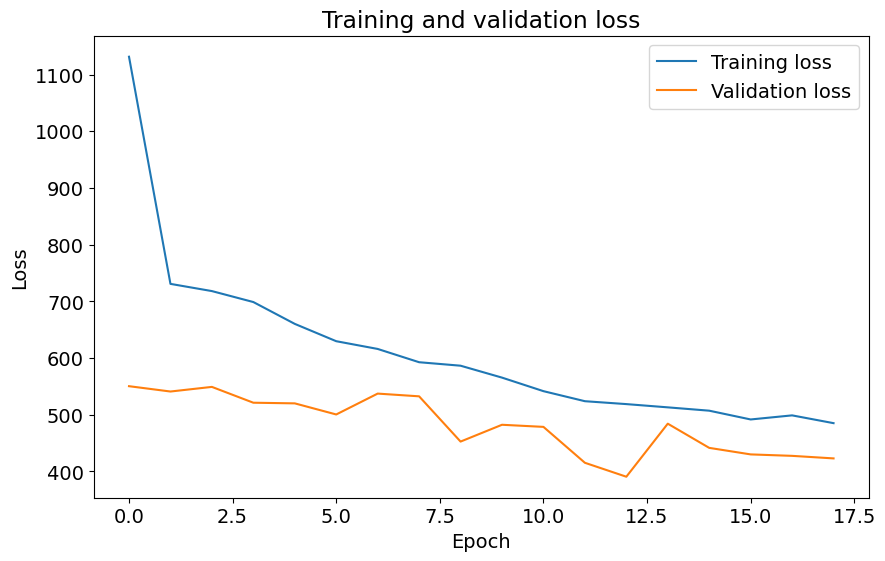

In [83]:
model23a, mean_crps23a, history23a, predicted_means_std23a = process_model(model23a, X_train=X_train_num, X_valid=X_valid_num, X_test=X_test_num, epochs = 200, loss_function=crps_normal_cost_function_v2)

In [84]:
X_train_num, X_valid_num, X_test_num = add_column(X_train_num, X_valid_num, X_test_num, X_train, X_valid, X_test, 'precipitation')

In [85]:
X_train_num.head()

,sun,windspeed_max,precip_indic,school_holiday_indicator,public_holiday_indicator,holiday_indicator,is_workday,season,day_of_week,temperature,humidity,windspeed,wind_direction,visibility,precipitation
0,-0.031329,0.665623,0,0,0,0,1,0,2,-0.039776,-0.645081,-0.218119,0.079113,1.461434,-0.397192
1,-0.458165,0.154228,0,0,0,0,1,0,3,0.244625,-0.607815,-0.324284,1.042128,1.392951,-0.397192
2,0.254435,-1.124262,1,0,0,0,1,0,4,0.381694,-0.417343,-1.076810,0.831722,0.906360,-0.371451
3,1.357699,-0.357168,0,0,0,0,0,0,5,1.300863,-1.551894,-0.405469,-0.349793,0.675680,-0.397192
4,0.059103,1.688415,1,0,0,0,0,0,6,0.745990,-0.897664,0.297096,0.532297,1.407369,0.555250


### Dropping the sun column

In [86]:
X_train_num = X_train_num.drop(columns=['sun'])
X_valid_num = X_valid_num.drop(columns=['sun'])
X_test_num = X_test_num.drop(columns=['sun'])

In [87]:
model24 = build_baseline_model(X_train_num.shape[1])

c:\Users\aisti\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



    Mean CRPS for baseline model with all predictors (except one-hot encoded holiday data): 397.22
    Columns in baseline model:
    'temperature', 'humidity', 'windspeed', 'wind_direction', 'visibility',
    'precipitation', 'sun', 'windspeed_max', 'precip_indic',
    'school_holiday_indicator', 'public_holiday_indicator',
    'holiday_indicator', 'is_workday', 'season', 'day_of_week'
    


Model information:

Callbacks: EarlyStopping (patience: 5), Learning Rate (Reduce on Plateau, patience: 5)
Batch size: 10
Epochs: 200

Epoch 1/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 1859.6517 - val_loss: 546.3785 - learning_rate: 0.0010
Epoch 2/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 737.0565 - val_loss: 625.3483 - learning_rate: 0.0010
Epoch 3/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 742.6974 - val_loss: 556.6946 - learning_rate: 0.0010
Epoch 4/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 736.7225 - val_loss: 531.4135 - learning_rate: 0.0010
Epoch 5/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 665.0778 - val_loss: 494.1140 - learning_rate: 0.0010
Epoch 6/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 644.2234 - val_loss: 613.3397 - learning_rate: 0.0010
Epoch 7/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 626.3140 - val_loss: 427.6193 - learning_rate: 0.0010
Epoch 8/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step -

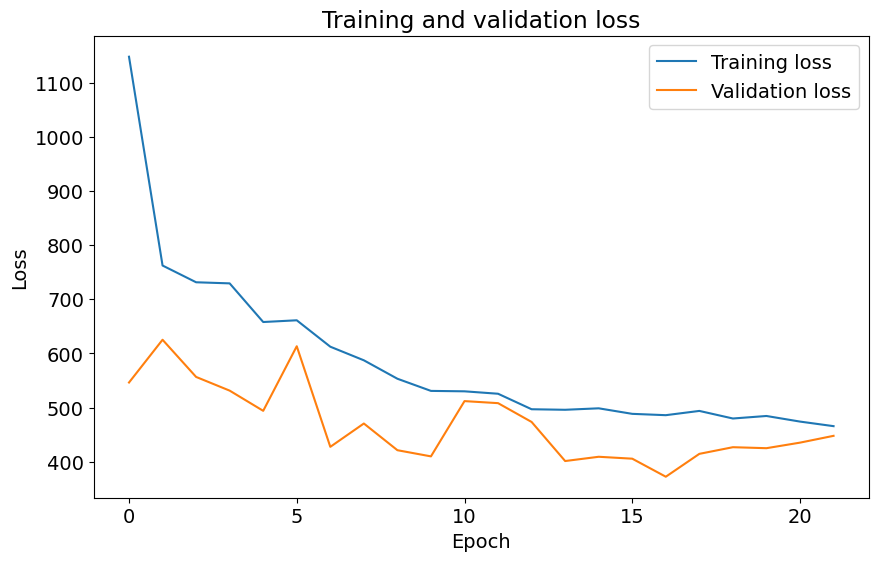

In [88]:
model24, mean_crps24, history24, predicted_means_std24 = process_model(model24, X_train=X_train_num, X_valid=X_valid_num, X_test=X_test_num, epochs = 200)

In [89]:
model24a = build_baseline_model2(X_train_num.shape[1])

Mean CRPS for baseline model with all predictors (except one-hot encoded holiday data): 342.76, loss function v2 used


c:\Users\aisti\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model information:

Callbacks: EarlyStopping (patience: 5), Learning Rate (Reduce on Plateau, patience: 5)
Batch size: 10
Epochs: 200

Epoch 1/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 1831.6677 - val_loss: 552.0894 - learning_rate: 0.0010
Epoch 2/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 693.8849 - val_loss: 560.5002 - learning_rate: 0.0010
Epoch 3/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 697.9557 - val_loss: 484.6152 - learning_rate: 0.0010
Epoch 4/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 683.3169 - val_loss: 595.4581 - learning_rate: 0.0010
Epoch 5/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 648.1503 - val_loss: 490.6348 - learning_rate: 0.0010
Epoch 6/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 656.0570 - val_loss: 490.3157 - learning_rate: 0.0010
Epoch 7/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 577.1531 - val_loss: 723.1119 - learning_rate: 0.0010
Epoch 8/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss

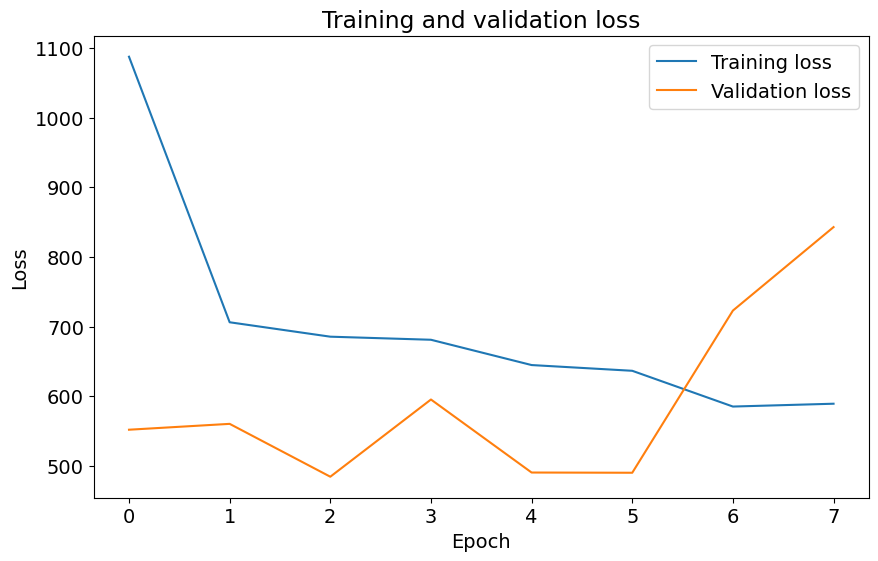

In [90]:
model24a, mean_crps24a, history24a, predicted_means_std24a = process_model(model24a, X_train=X_train_num, X_valid=X_valid_num, X_test=X_test_num, epochs = 200, loss_function=crps_normal_cost_function_v2)

In [91]:
X_train_num, X_valid_num, X_test_num = add_column(X_train_num, X_valid_num, X_test_num, X_train, X_valid, X_test, 'sun')

In [92]:
model25 = build_baseline_model(X_train_num.shape[1])


    Mean CRPS for baseline model with all predictors (except one-hot encoded holiday data): 397.22
    Columns in baseline model:
    'temperature', 'humidity', 'windspeed', 'wind_direction', 'visibility',
    'precipitation', 'sun', 'windspeed_max', 'precip_indic',
    'school_holiday_indicator', 'public_holiday_indicator',
    'holiday_indicator', 'is_workday', 'season', 'day_of_week'
    


c:\Users\aisti\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model information:

Callbacks: EarlyStopping (patience: 5), Learning Rate (Reduce on Plateau, patience: 5)
Batch size: 10
Epochs: 200

Epoch 1/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step - loss: 1974.0181 - val_loss: 559.8770 - learning_rate: 0.0010
Epoch 2/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 797.8575 - val_loss: 540.8676 - learning_rate: 0.0010
Epoch 3/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 759.5512 - val_loss: 811.9867 - learning_rate: 0.0010
Epoch 4/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 727.9155 - val_loss: 566.3365 - learning_rate: 0.0010
Epoch 5/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 669.8712 - val_loss: 478.6195 - learning_rate: 0.0010
Epoch 6/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 650.7484 - val_loss: 584.7111 - learning_rate: 0.0010
Epoch 7/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 614.7796 - val_loss: 545.7099 - learning_rate: 0.0010
Epoch 8/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - los

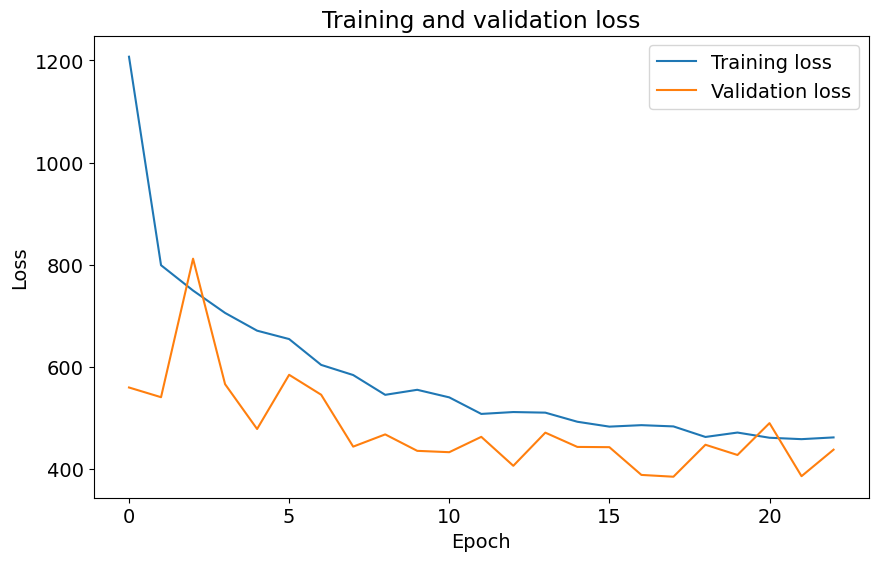

In [93]:
model25, mean_crps25, history25, predicted_means_std25 = process_model(model25, X_train=X_train_num, X_valid=X_valid_num, X_test=X_test_num, epochs = 200)

In [94]:
X_train_num.head()

,windspeed_max,precip_indic,school_holiday_indicator,public_holiday_indicator,holiday_indicator,is_workday,season,day_of_week,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun
0,0.665623,0,0,0,0,1,0,2,-0.039776,-0.645081,-0.218119,0.079113,1.461434,-0.397192,-0.031329
1,0.154228,0,0,0,0,1,0,3,0.244625,-0.607815,-0.324284,1.042128,1.392951,-0.397192,-0.458165
2,-1.124262,1,0,0,0,1,0,4,0.381694,-0.417343,-1.076810,0.831722,0.906360,-0.371451,0.254435
3,-0.357168,0,0,0,0,0,0,5,1.300863,-1.551894,-0.405469,-0.349793,0.675680,-0.397192,1.357699
4,1.688415,1,0,0,0,0,0,6,0.745990,-0.897664,0.297096,0.532297,1.407369,0.555250,0.059103


### Dropping the windspeed max column

In [95]:
X_train_num = X_train_num.drop(columns=['windspeed_max'])
X_valid_num = X_valid_num.drop(columns=['windspeed_max'])
X_test_num = X_test_num.drop(columns=['windspeed_max'])

In [96]:
X_test_num.shape

(390, 14)

In [97]:
model26 = build_baseline_model(X_train_num.shape[1])


    Mean CRPS for baseline model with all predictors (except one-hot encoded holiday data): 397.22
    Columns in baseline model:
    'temperature', 'humidity', 'windspeed', 'wind_direction', 'visibility',
    'precipitation', 'sun', 'windspeed_max', 'precip_indic',
    'school_holiday_indicator', 'public_holiday_indicator',
    'holiday_indicator', 'is_workday', 'season', 'day_of_week'
    


c:\Users\aisti\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model information:

Callbacks: EarlyStopping (patience: 5), Learning Rate (Reduce on Plateau, patience: 5)
Batch size: 10
Epochs: 200

Epoch 1/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 1903.1550 - val_loss: 644.6398 - learning_rate: 0.0010
Epoch 2/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 803.3702 - val_loss: 595.2093 - learning_rate: 0.0010
Epoch 3/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 752.0767 - val_loss: 506.6831 - learning_rate: 0.0010
Epoch 4/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 693.7443 - val_loss: 489.5798 - learning_rate: 0.0010
Epoch 5/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 679.9702 - val_loss: 490.7307 - learning_rate: 0.0010
Epoch 6/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 628.1366 - val_loss: 558.5588 - learning_rate: 0.0010
Epoch 7/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 592.7261 - val_loss: 537.0394 - learning_rate: 0.0010
Epoch 8/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - los

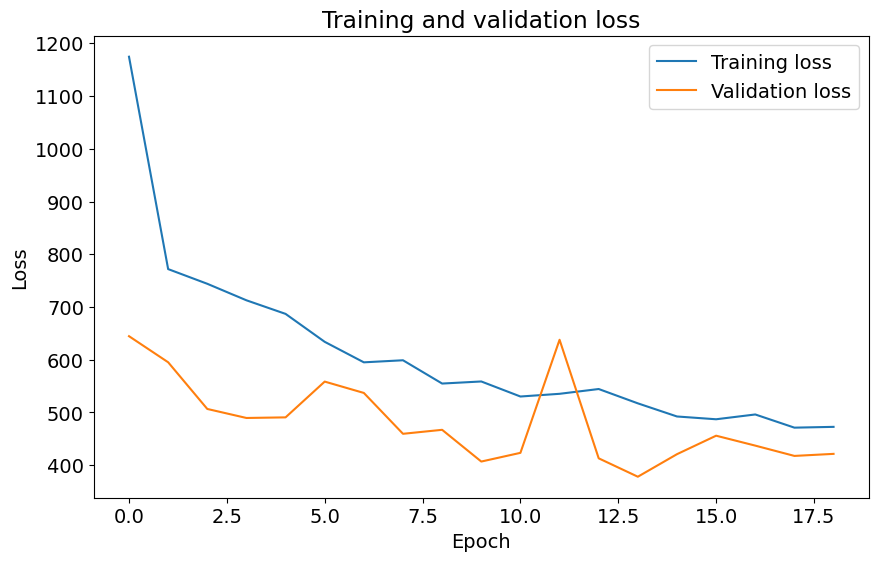

In [98]:
model26, mean_crps26, history26, predicted_means_std26 = process_model(model26, X_train=X_train_num, X_valid=X_valid_num, X_test=X_test_num, epochs = 200)

In [99]:
model26a = build_baseline_model2(X_train_num.shape[1])

Mean CRPS for baseline model with all predictors (except one-hot encoded holiday data): 342.76, loss function v2 used


c:\Users\aisti\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model information:

Callbacks: EarlyStopping (patience: 5), Learning Rate (Reduce on Plateau, patience: 5)
Batch size: 10
Epochs: 200

Epoch 1/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - loss: 1864.6630 - val_loss: 559.5349 - learning_rate: 0.0010
Epoch 2/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 708.7568 - val_loss: 529.7876 - learning_rate: 0.0010
Epoch 3/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 701.8269 - val_loss: 500.5207 - learning_rate: 0.0010
Epoch 4/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 690.3878 - val_loss: 501.1710 - learning_rate: 0.0010
Epoch 5/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 637.8922 - val_loss: 486.4684 - learning_rate: 0.0010
Epoch 6/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 640.1909 - val_loss: 602.9813 - learning_rate: 0.0010
Epoch 7/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 604.2958 - val_loss: 457.5036 - learning_rate: 0.0010
Epoch 8/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - los

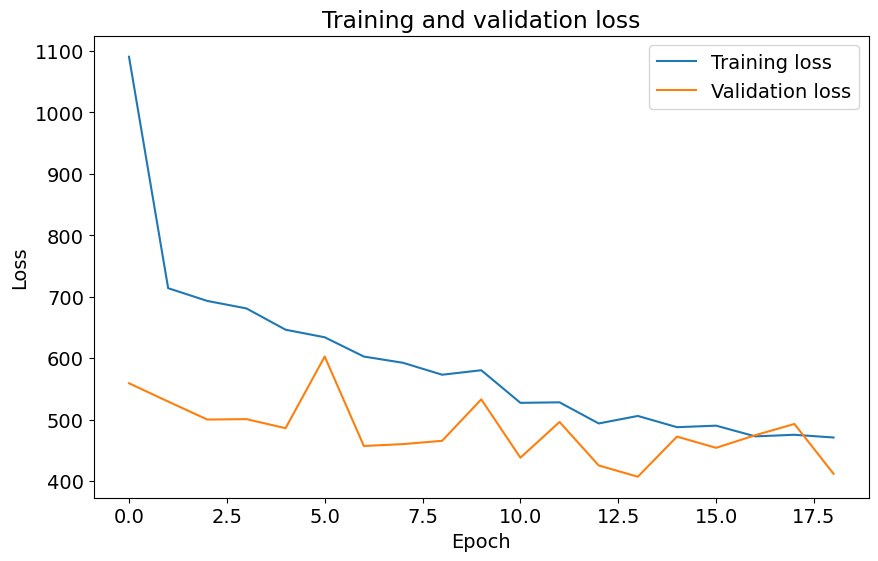

In [100]:
model26a, mean_crps26a, history26a, predicted_means_std26a = process_model(model26a, X_train=X_train_num, X_valid=X_valid_num, X_test=X_test_num, epochs = 200, loss_function=crps_normal_cost_function_v2)

In [101]:
X_train_num, X_valid_num, X_test_num = add_column(X_train_num, X_valid_num, X_test_num, X_train, X_valid, X_test, 'windspeed_max')

### Dropping the precip indic column

In [102]:
X_train_num = X_train_num.drop(columns=['precip_indic'])
X_valid_num = X_valid_num.drop(columns=['precip_indic'])
X_test_num = X_test_num.drop(columns=['precip_indic'])

In [103]:
model27 = build_baseline_model(X_train_num.shape[1])


    Mean CRPS for baseline model with all predictors (except one-hot encoded holiday data): 397.22
    Columns in baseline model:
    'temperature', 'humidity', 'windspeed', 'wind_direction', 'visibility',
    'precipitation', 'sun', 'windspeed_max', 'precip_indic',
    'school_holiday_indicator', 'public_holiday_indicator',
    'holiday_indicator', 'is_workday', 'season', 'day_of_week'
    


c:\Users\aisti\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model information:

Callbacks: EarlyStopping (patience: 5), Learning Rate (Reduce on Plateau, patience: 5)
Batch size: 10
Epochs: 200

Epoch 1/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 1903.3488 - val_loss: 739.3339 - learning_rate: 0.0010
Epoch 2/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 787.3787 - val_loss: 661.8053 - learning_rate: 0.0010
Epoch 3/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 809.6729 - val_loss: 501.6749 - learning_rate: 0.0010
Epoch 4/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 724.6219 - val_loss: 685.1962 - learning_rate: 0.0010
Epoch 5/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 698.8417 - val_loss: 524.6521 - learning_rate: 0.0010
Epoch 6/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 673.1359 - val_loss: 526.4309 - learning_rate: 0.0010
Epoch 7/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 663.8117 - val_loss: 498.1976 - learning_rate: 0.0010
Epoch 8/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - lo

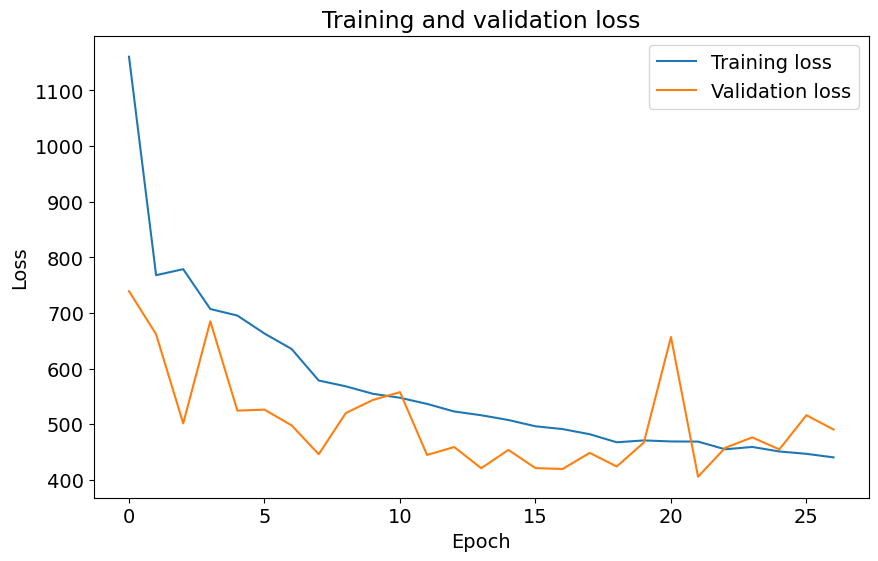

In [104]:
model27, mean_crps27, history27, predicted_means_std27 = process_model(model27, X_train=X_train_num, X_valid=X_valid_num, X_test=X_test_num, epochs = 200)

In [105]:
model28 = build_baseline_model2(X_train_num.shape[1])

Mean CRPS for baseline model with all predictors (except one-hot encoded holiday data): 342.76, loss function v2 used


c:\Users\aisti\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model information:

Callbacks: EarlyStopping (patience: 5), Learning Rate (Reduce on Plateau, patience: 5)
Batch size: 10
Epochs: 200

Epoch 1/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 1893.4490 - val_loss: 560.6298 - learning_rate: 0.0010
Epoch 2/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 728.3431 - val_loss: 519.0724 - learning_rate: 0.0010
Epoch 3/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 674.4556 - val_loss: 538.2930 - learning_rate: 0.0010
Epoch 4/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 667.9462 - val_loss: 561.4285 - learning_rate: 0.0010
Epoch 5/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 682.9451 - val_loss: 737.1089 - learning_rate: 0.0010
Epoch 6/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 625.6646 - val_loss: 558.5939 - learning_rate: 0.0010
Epoch 7/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 614.4639 - val_loss: 483.1958 - learning_rate: 0.0010
Epoch 8/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - 

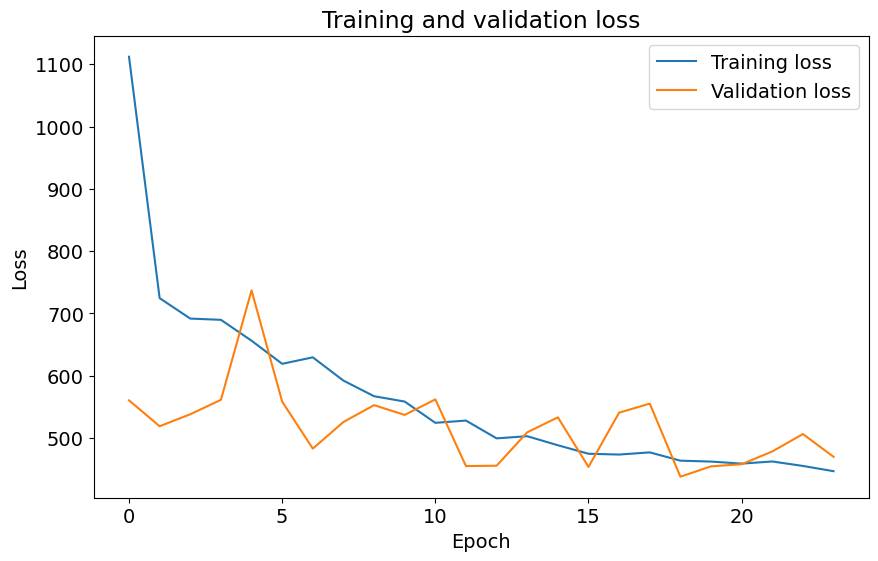

In [106]:
model28, mean_crps28, history28, predicted_means_std28 = process_model(model28, X_train=X_train_num, X_valid=X_valid_num, X_test=X_test_num, epochs = 200, loss_function=crps_normal_cost_function_v2)

In [107]:
X_train_num, X_valid_num, X_test_num = add_column(X_train_num, X_valid_num, X_test_num, X_train, X_valid, X_test, 'precip_indic')

In [108]:
X_train_num.head()

,school_holiday_indicator,public_holiday_indicator,holiday_indicator,is_workday,season,day_of_week,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic
0,0,0,0,1,0,2,-0.039776,-0.645081,-0.218119,0.079113,1.461434,-0.397192,-0.031329,0.665623,0
1,0,0,0,1,0,3,0.244625,-0.607815,-0.324284,1.042128,1.392951,-0.397192,-0.458165,0.154228,0
2,0,0,0,1,0,4,0.381694,-0.417343,-1.076810,0.831722,0.906360,-0.371451,0.254435,-1.124262,1
3,0,0,0,0,0,5,1.300863,-1.551894,-0.405469,-0.349793,0.675680,-0.397192,1.357699,-0.357168,0
4,0,0,0,0,0,6,0.745990,-0.897664,0.297096,0.532297,1.407369,0.555250,0.059103,1.688415,1


In [109]:
X_train_num.shape

(3161, 15)

### Dropping the school holiday indicator column

In [110]:
X_train_num = X_train_num.drop(columns=['school_holiday_indicator'])
X_valid_num = X_valid_num.drop(columns=['school_holiday_indicator'])
X_test_num = X_test_num.drop(columns=['school_holiday_indicator'])

In [111]:
model29 = build_baseline_model(X_train_num.shape[1])

c:\Users\aisti\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



    Mean CRPS for baseline model with all predictors (except one-hot encoded holiday data): 397.22
    Columns in baseline model:
    'temperature', 'humidity', 'windspeed', 'wind_direction', 'visibility',
    'precipitation', 'sun', 'windspeed_max', 'precip_indic',
    'school_holiday_indicator', 'public_holiday_indicator',
    'holiday_indicator', 'is_workday', 'season', 'day_of_week'
    


Model information:

Callbacks: EarlyStopping (patience: 5), Learning Rate (Reduce on Plateau, patience: 5)
Batch size: 10
Epochs: 200

Epoch 1/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 1842.9343 - val_loss: 602.7669 - learning_rate: 0.0010
Epoch 2/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 835.7589 - val_loss: 532.4655 - learning_rate: 0.0010
Epoch 3/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 759.1702 - val_loss: 608.9125 - learning_rate: 0.0010
Epoch 4/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 698.7921 - val_loss: 527.6617 - learning_rate: 0.0010
Epoch 5/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 711.5739 - val_loss: 487.6451 - learning_rate: 0.0010
Epoch 6/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 660.3097 - val_loss: 501.4267 - learning_rate: 0.0010
Epoch 7/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 666.9255 - val_loss: 496.1437 - learning_rate: 0.0010
Epoch 8/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - lo

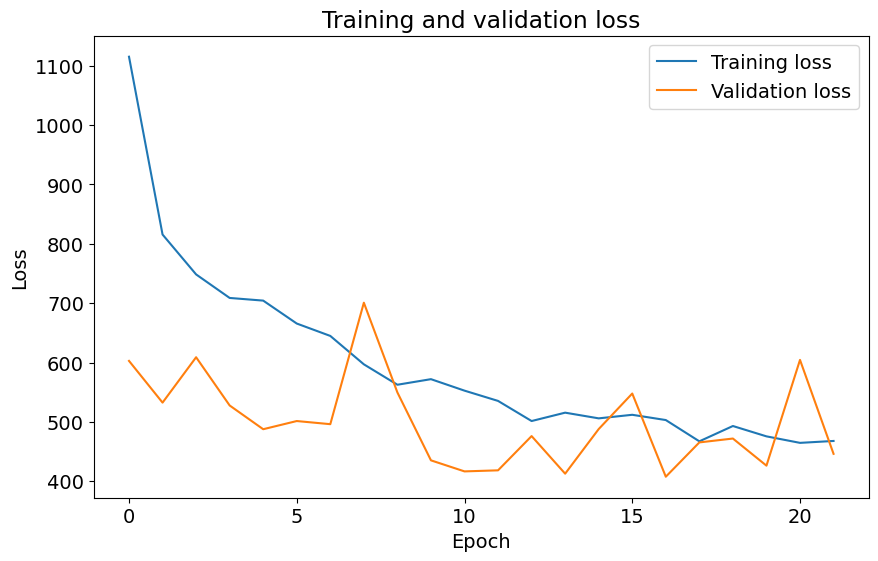

In [112]:
model29, mean_crps29, history29, predicted_means_std29 = process_model(model29, X_train=X_train_num, X_valid=X_valid_num, X_test=X_test_num, epochs = 200)

In [113]:
model30 = build_baseline_model2(X_train_num.shape[1])

Mean CRPS for baseline model with all predictors (except one-hot encoded holiday data): 342.76, loss function v2 used


c:\Users\aisti\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model information:

Callbacks: EarlyStopping (patience: 5), Learning Rate (Reduce on Plateau, patience: 5)
Batch size: 10
Epochs: 200

Epoch 1/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 1892.2661 - val_loss: 585.8613 - learning_rate: 0.0010
Epoch 2/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 737.3311 - val_loss: 522.5818 - learning_rate: 0.0010
Epoch 3/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 687.3111 - val_loss: 537.3153 - learning_rate: 0.0010
Epoch 4/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 657.8094 - val_loss: 605.4488 - learning_rate: 0.0010
Epoch 5/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 649.6282 - val_loss: 580.1349 - learning_rate: 0.0010
Epoch 6/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 617.9756 - val_loss: 552.8856 - learning_rate: 0.0010
Epoch 7/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 591.0452 - val_loss: 500.2722 - learning_rate: 0.0010
Epoch 8/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - l

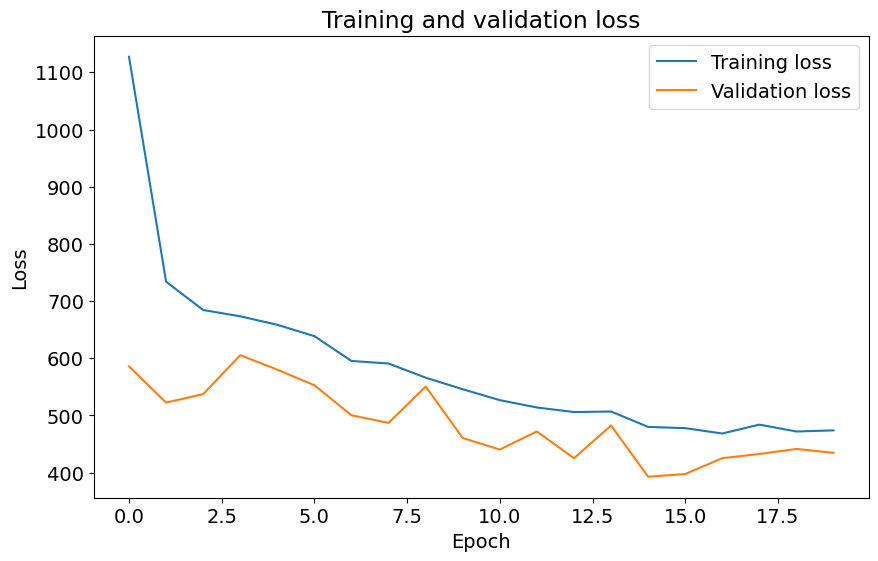

In [114]:
model30, mean_crps30, history30, predicted_means_std30 = process_model(model30, X_train=X_train_num, X_valid=X_valid_num, X_test=X_test_num, epochs = 200, loss_function=crps_normal_cost_function_v2)

In [115]:
X_train_num, X_valid_num, X_test_num = add_column(X_train_num, X_valid_num, X_test_num, X_train, X_valid, X_test, 'school_holiday_indicator')

In [116]:
X_test_num.head()

,public_holiday_indicator,holiday_indicator,is_workday,season,day_of_week,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,school_holiday_indicator
0,1,1,0,3,6,0.156666,-0.574689,-0.146301,0.435186,1.740197,-0.397192,-0.385820,0.154228,0,1
1,0,1,1,3,0,-0.267002,0.406656,-0.196261,0.386631,1.259373,0.014675,-0.736694,0.819042,1,1
2,0,1,1,3,1,-0.832871,1.040183,-1.011237,0.313798,0.940566,-0.397192,0.160386,-0.996413,0,1
3,0,1,1,3,2,-0.452449,0.216184,3.104234,0.726518,1.005769,-0.319967,-1.094803,1.995252,1,1
4,0,1,1,3,3,-0.179777,0.572284,1.486773,0.807444,0.600781,-0.319967,-1.015223,1.253728,1,1


### Dropping the public holiday indicator column

In [117]:
X_train_num = X_train_num.drop(columns=['public_holiday_indicator'])
X_valid_num = X_valid_num.drop(columns=['public_holiday_indicator'])
X_test_num = X_test_num.drop(columns=['public_holiday_indicator'])

In [118]:
model31 = build_baseline_model(X_train_num.shape[1])

c:\Users\aisti\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



    Mean CRPS for baseline model with all predictors (except one-hot encoded holiday data): 397.22
    Columns in baseline model:
    'temperature', 'humidity', 'windspeed', 'wind_direction', 'visibility',
    'precipitation', 'sun', 'windspeed_max', 'precip_indic',
    'school_holiday_indicator', 'public_holiday_indicator',
    'holiday_indicator', 'is_workday', 'season', 'day_of_week'
    


Model information:

Callbacks: EarlyStopping (patience: 5), Learning Rate (Reduce on Plateau, patience: 5)
Batch size: 10
Epochs: 200

Epoch 1/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 10s 9ms/step - loss: 1881.7706 - val_loss: 587.9498 - learning_rate: 0.0010
Epoch 2/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 761.9692 - val_loss: 538.2731 - learning_rate: 0.0010
Epoch 3/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 759.9548 - val_loss: 516.7409 - learning_rate: 0.0010
Epoch 4/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 715.4872 - val_loss: 501.0161 - learning_rate: 0.0010
Epoch 5/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 692.0076 - val_loss: 542.0502 - learning_rate: 0.0010
Epoch 6/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 670.1071 - val_loss: 558.3490 - learning_rate: 0.0010
Epoch 7/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 681.1245 - val_loss: 510.1888 - learning_rate: 0.0010
Epoch 8/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - los

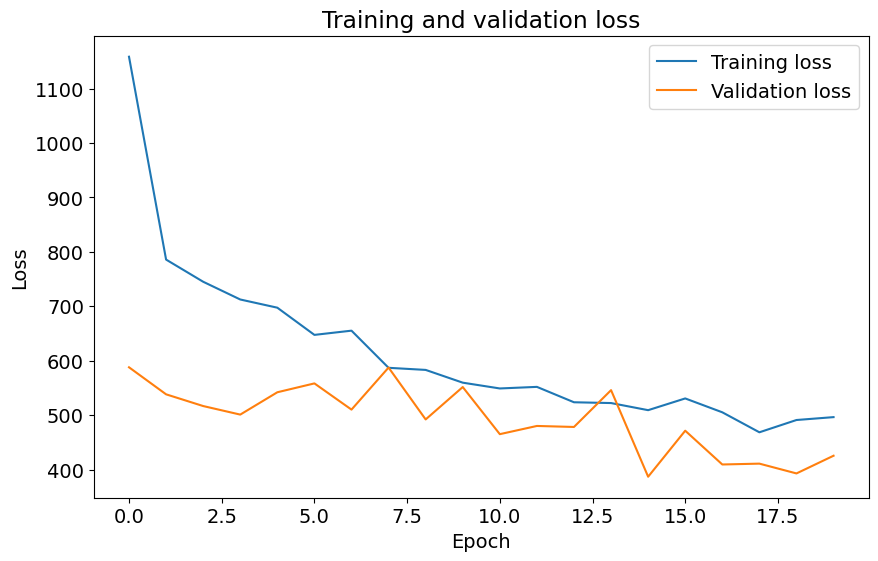

In [119]:
model31, mean_crps31, history31, predicted_means_std31 = process_model(model31, X_train=X_train_num, X_valid=X_valid_num, X_test=X_test_num, epochs = 200)

In [120]:
model31a = build_baseline_model2(X_train_num.shape[1])

Mean CRPS for baseline model with all predictors (except one-hot encoded holiday data): 342.76, loss function v2 used


c:\Users\aisti\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model information:

Callbacks: EarlyStopping (patience: 5), Learning Rate (Reduce on Plateau, patience: 5)
Batch size: 10
Epochs: 200

Epoch 1/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 1900.0914 - val_loss: 531.6282 - learning_rate: 0.0010
Epoch 2/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 735.4792 - val_loss: 637.5918 - learning_rate: 0.0010
Epoch 3/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 707.7911 - val_loss: 509.3288 - learning_rate: 0.0010
Epoch 4/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 696.0579 - val_loss: 568.6849 - learning_rate: 0.0010
Epoch 5/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 646.9448 - val_loss: 656.8220 - learning_rate: 0.0010
Epoch 6/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 633.6229 - val_loss: 548.8851 - learning_rate: 0.0010
Epoch 7/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 590.6432 - val_loss: 658.1650 - learning_rate: 0.0010
Epoch 8/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss

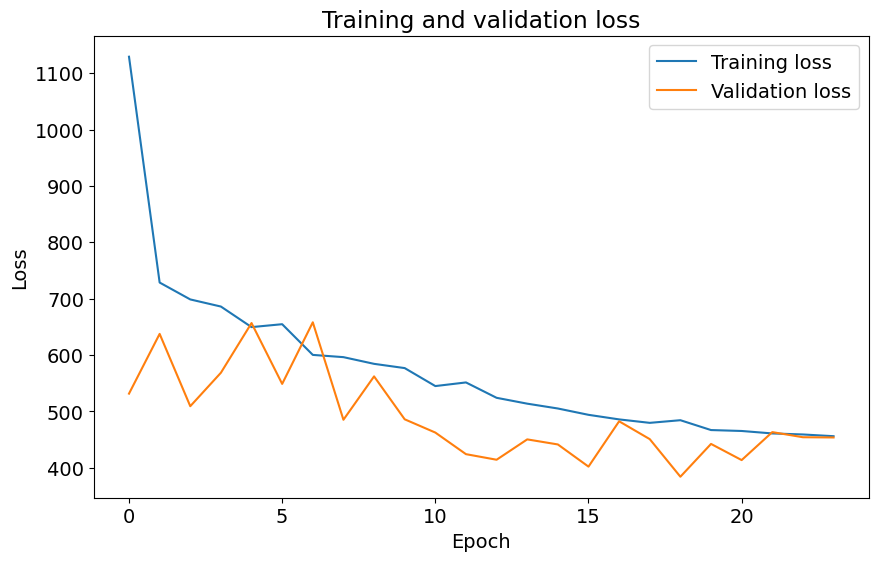

In [121]:
model31a, mean_crps31a, history31a, predicted_means_std31a = process_model(model31a, X_train=X_train_num, X_valid=X_valid_num, X_test=X_test_num, epochs = 200, loss_function=crps_normal_cost_function_v2)

In [122]:
X_train_num, X_valid_num, X_test_num = add_column(X_train_num, X_valid_num, X_test_num, X_train, X_valid, X_test, 'public_holiday_indicator')

In [123]:
model32 = build_baseline_model(X_train_num.shape[1])

c:\Users\aisti\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



    Mean CRPS for baseline model with all predictors (except one-hot encoded holiday data): 397.22
    Columns in baseline model:
    'temperature', 'humidity', 'windspeed', 'wind_direction', 'visibility',
    'precipitation', 'sun', 'windspeed_max', 'precip_indic',
    'school_holiday_indicator', 'public_holiday_indicator',
    'holiday_indicator', 'is_workday', 'season', 'day_of_week'
    


Model information:

Callbacks: EarlyStopping (patience: 5), Learning Rate (Reduce on Plateau, patience: 5)
Batch size: 10
Epochs: 200

Epoch 1/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 11s 12ms/step - loss: 1984.7262 - val_loss: 728.3340 - learning_rate: 0.0010
Epoch 2/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 785.0291 - val_loss: 648.3254 - learning_rate: 0.0010
Epoch 3/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 806.2081 - val_loss: 533.5668 - learning_rate: 0.0010
Epoch 4/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 692.0903 - val_loss: 535.9704 - learning_rate: 0.0010
Epoch 5/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 688.3931 - val_loss: 531.5876 - learning_rate: 0.0010
Epoch 6/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 660.7776 - val_loss: 566.7211 - learning_rate: 0.0010
Epoch 7/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 670.3893 - val_loss: 456.8525 - learning_rate: 0.0010
Epoch 8/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step 

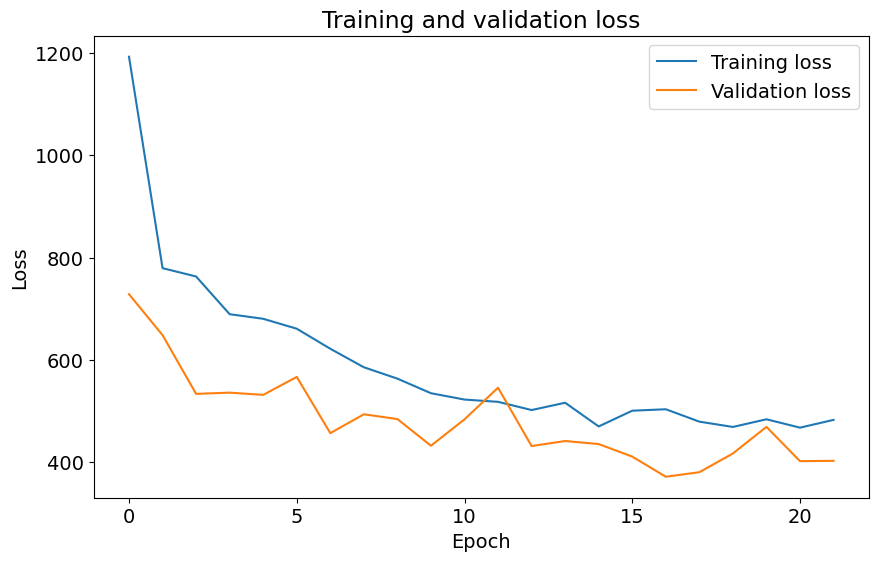

In [124]:
model32, mean_crps32, history32, predicted_means_std32 = process_model(model32, X_train=X_train_num, X_valid=X_valid_num, X_test=X_test_num, epochs = 200)

In [125]:
model32a = build_baseline_model2(X_train_num.shape[1])

Mean CRPS for baseline model with all predictors (except one-hot encoded holiday data): 342.76, loss function v2 used


c:\Users\aisti\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model information:

Callbacks: EarlyStopping (patience: 5), Learning Rate (Reduce on Plateau, patience: 5)
Batch size: 10
Epochs: 200

Epoch 1/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 1888.0173 - val_loss: 516.4678 - learning_rate: 0.0010
Epoch 2/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 724.2031 - val_loss: 624.0539 - learning_rate: 0.0010
Epoch 3/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 697.0214 - val_loss: 604.7275 - learning_rate: 0.0010
Epoch 4/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 670.5601 - val_loss: 478.1382 - learning_rate: 0.0010
Epoch 5/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 673.3271 - val_loss: 485.2515 - learning_rate: 0.0010
Epoch 6/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 627.0139 - val_loss: 636.3499 - learning_rate: 0.0010
Epoch 7/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 581.0334 - val_loss: 535.6285 - learning_rate: 0.0010
Epoch 8/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - lo

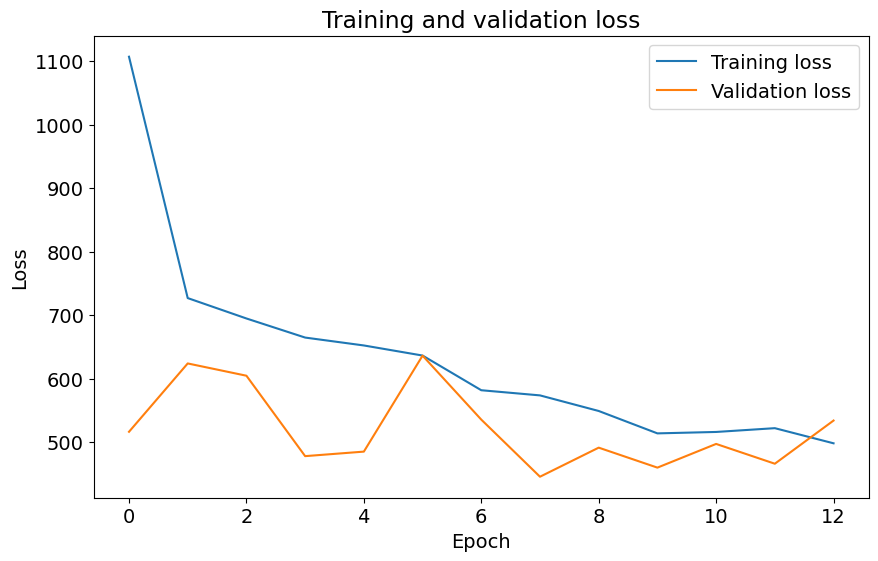

In [126]:
model32a, mean_crps32a, history32a, predicted_means_std32a = process_model(model32a, X_train=X_train_num, X_valid=X_valid_num, X_test=X_test_num, epochs = 200, loss_function=crps_normal_cost_function_v2)

### Dropping the holiday indicator column

In [127]:
X_train_num = X_train_num.drop(columns=['holiday_indicator'])
X_valid_num = X_valid_num.drop(columns=['holiday_indicator'])
X_test_num = X_test_num.drop(columns=['holiday_indicator'])

In [128]:
X_test_num.head()

,is_workday,season,day_of_week,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,school_holiday_indicator,public_holiday_indicator
0,0,3,6,0.156666,-0.574689,-0.146301,0.435186,1.740197,-0.397192,-0.385820,0.154228,0,1,1
1,1,3,0,-0.267002,0.406656,-0.196261,0.386631,1.259373,0.014675,-0.736694,0.819042,1,1,0
2,1,3,1,-0.832871,1.040183,-1.011237,0.313798,0.940566,-0.397192,0.160386,-0.996413,0,1,0
3,1,3,2,-0.452449,0.216184,3.104234,0.726518,1.005769,-0.319967,-1.094803,1.995252,1,1,0
4,1,3,3,-0.179777,0.572284,1.486773,0.807444,0.600781,-0.319967,-1.015223,1.253728,1,1,0


In [129]:
model33 = build_baseline_model(X_train_num.shape[1])

c:\Users\aisti\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



    Mean CRPS for baseline model with all predictors (except one-hot encoded holiday data): 397.22
    Columns in baseline model:
    'temperature', 'humidity', 'windspeed', 'wind_direction', 'visibility',
    'precipitation', 'sun', 'windspeed_max', 'precip_indic',
    'school_holiday_indicator', 'public_holiday_indicator',
    'holiday_indicator', 'is_workday', 'season', 'day_of_week'
    


Model information:

Callbacks: EarlyStopping (patience: 5), Learning Rate (Reduce on Plateau, patience: 5)
Batch size: 10
Epochs: 200

Epoch 1/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 14s 16ms/step - loss: 1964.7874 - val_loss: 525.5260 - learning_rate: 0.0010
Epoch 2/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 791.3749 - val_loss: 633.7389 - learning_rate: 0.0010
Epoch 3/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 734.8602 - val_loss: 518.7501 - learning_rate: 0.0010
Epoch 4/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 715.7736 - val_loss: 503.7844 - learning_rate: 0.0010
Epoch 5/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 704.1818 - val_loss: 491.1897 - learning_rate: 0.0010
Epoch 6/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 682.1646 - val_loss: 471.8936 - learning_rate: 0.0010
Epoch 7/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 630.6658 - val_loss: 504.6241 - learning_rate: 0.0010
Epoch 8/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step -

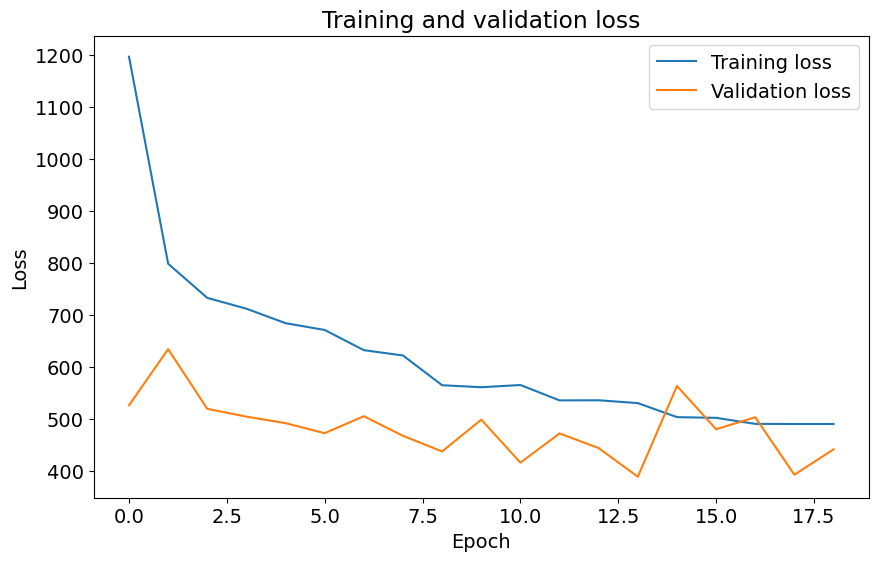

In [130]:
model33, mean_crps33, history33, predicted_means_std33 = process_model(model33, X_train=X_train_num, X_valid=X_valid_num, X_test=X_test_num, epochs = 200)

In [131]:
model33a = build_baseline_model2(X_train_num.shape[1])

Mean CRPS for baseline model with all predictors (except one-hot encoded holiday data): 342.76, loss function v2 used


c:\Users\aisti\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model information:

Callbacks: EarlyStopping (patience: 5), Learning Rate (Reduce on Plateau, patience: 5)
Batch size: 10
Epochs: 200

Epoch 1/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 10s 10ms/step - loss: 1859.0992 - val_loss: 510.2918 - learning_rate: 0.0010
Epoch 2/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 769.5037 - val_loss: 556.4620 - learning_rate: 0.0010
Epoch 3/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 682.0889 - val_loss: 516.1885 - learning_rate: 0.0010
Epoch 4/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 665.3165 - val_loss: 477.3878 - learning_rate: 0.0010
Epoch 5/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 663.8569 - val_loss: 519.3782 - learning_rate: 0.0010
Epoch 6/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 606.7613 - val_loss: 498.2120 - learning_rate: 0.0010
Epoch 7/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 603.4507 - val_loss: 488.2369 - learning_rate: 0.0010
Epoch 8/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - 

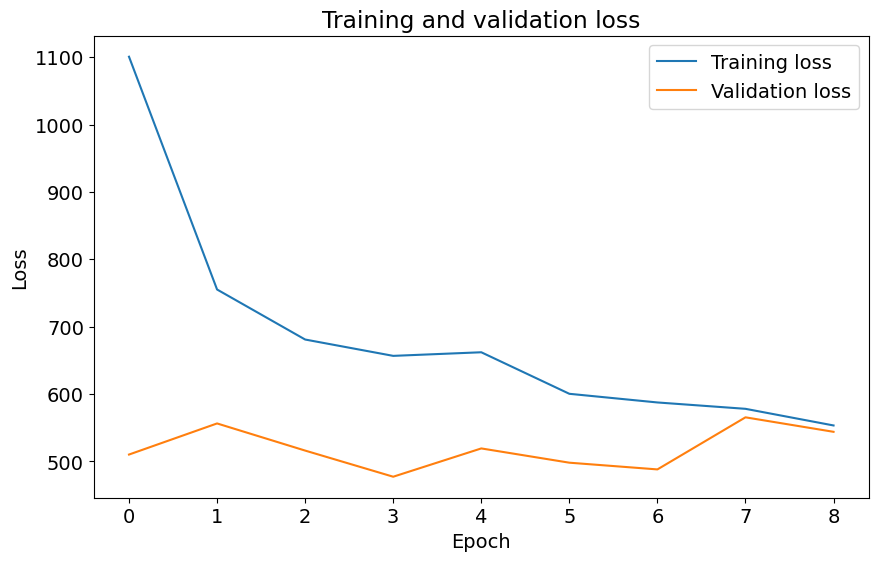

In [132]:
model33a, mean_crps33a, history33a, predicted_means_std33a = process_model(model33a, X_train=X_train_num, X_valid=X_valid_num, X_test=X_test_num, epochs = 200, loss_function=crps_normal_cost_function_v2)

In [133]:
X_train_num, X_valid_num, X_test_num = add_column(X_train_num, X_valid_num, X_test_num, X_train, X_valid, X_test, 'holiday_indicator')

In [134]:
X_valid_num.head()

,is_workday,season,day_of_week,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,school_holiday_indicator,public_holiday_indicator,holiday_indicator
0,0,3,6,-0.598314,0.671661,0.219033,0.532297,0.294482,-0.397192,-0.711374,0.767902,0,1,0,1
1,1,3,0,-0.121137,-0.023976,2.264278,0.783166,1.320575,-0.345709,-1.065865,2.123101,1,1,0,1
2,1,3,1,-0.392344,1.301047,1.527366,0.993573,-0.958363,10.002447,-1.094803,1.432717,1,1,0,1
3,1,3,2,-1.117271,-0.044680,1.805269,0.969295,1.270619,-0.165517,-0.479869,1.125879,1,1,0,1
4,0,3,3,-1.243345,0.998776,-0.005788,0.483741,-0.028579,-0.397192,-0.913940,-0.485017,0,1,1,1


### Dropping the is workday column

In [135]:
X_train_num = X_train_num.drop(columns=['is_workday'])
X_valid_num = X_valid_num.drop(columns=['is_workday'])
X_test_num = X_test_num.drop(columns=['is_workday'])

In [136]:
model34 = build_baseline_model(X_train_num.shape[1])

c:\Users\aisti\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



    Mean CRPS for baseline model with all predictors (except one-hot encoded holiday data): 397.22
    Columns in baseline model:
    'temperature', 'humidity', 'windspeed', 'wind_direction', 'visibility',
    'precipitation', 'sun', 'windspeed_max', 'precip_indic',
    'school_holiday_indicator', 'public_holiday_indicator',
    'holiday_indicator', 'is_workday', 'season', 'day_of_week'
    


Model information:

Callbacks: EarlyStopping (patience: 5), Learning Rate (Reduce on Plateau, patience: 5)
Batch size: 10
Epochs: 200

Epoch 1/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 20s 12ms/step - loss: 2047.8390 - val_loss: 694.6135 - learning_rate: 0.0010
Epoch 2/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 878.5109 - val_loss: 531.1429 - learning_rate: 0.0010
Epoch 3/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 693.0167 - val_loss: 451.6365 - learning_rate: 0.0010
Epoch 4/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 646.1016 - val_loss: 458.4357 - learning_rate: 0.0010
Epoch 5/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 619.2457 - val_loss: 608.3950 - learning_rate: 0.0010
Epoch 6/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 660.1625 - val_loss: 452.9196 - learning_rate: 0.0010
Epoch 7/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - loss: 572.0408 - val_loss: 485.3470 - learning_rate: 0.0010
Epoch 8/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step -

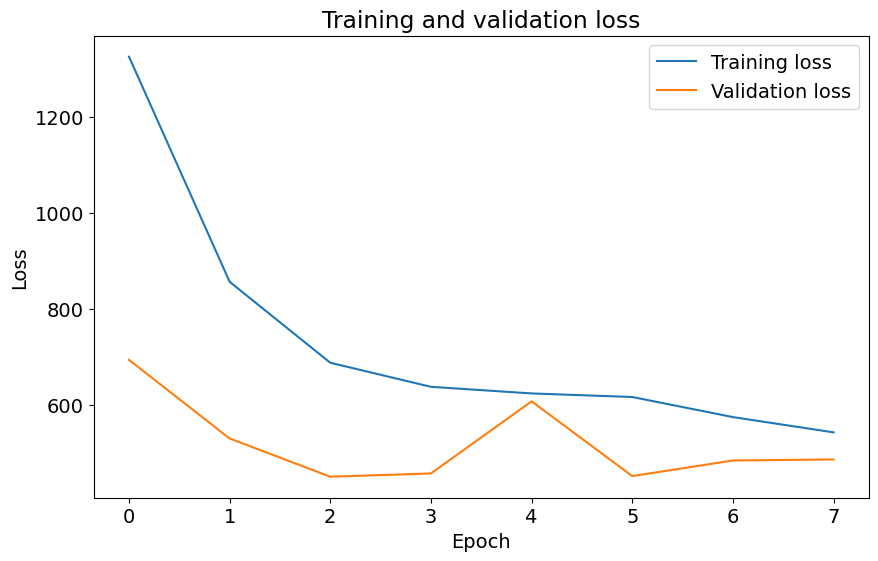

In [137]:
model34, mean_crps34, history34, predicted_means_std34 = process_model(model34, X_train=X_train_num, X_valid=X_valid_num, X_test=X_test_num, epochs = 200)

In [138]:
model35 = build_baseline_model2(X_train_num.shape[1])

c:\Users\aisti\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Mean CRPS for baseline model with all predictors (except one-hot encoded holiday data): 342.76, loss function v2 used


Model information:

Callbacks: EarlyStopping (patience: 5), Learning Rate (Reduce on Plateau, patience: 5)
Batch size: 10
Epochs: 200

Epoch 1/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 15s 21ms/step - loss: 2055.5742 - val_loss: 739.9367 - learning_rate: 0.0010
Epoch 2/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 812.2315 - val_loss: 573.2657 - learning_rate: 0.0010
Epoch 3/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 711.4598 - val_loss: 546.7447 - learning_rate: 0.0010
Epoch 4/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 674.0114 - val_loss: 485.2657 - learning_rate: 0.0010
Epoch 5/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 602.0577 - val_loss: 507.7188 - learning_rate: 0.0010
Epoch 6/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 576.3191 - val_loss: 436.4681 - learning_rate: 0.0010
Epoch 7/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 562.8426 - val_loss: 463.7634 - learning_rate: 0.0010
Epoch 8/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/ste

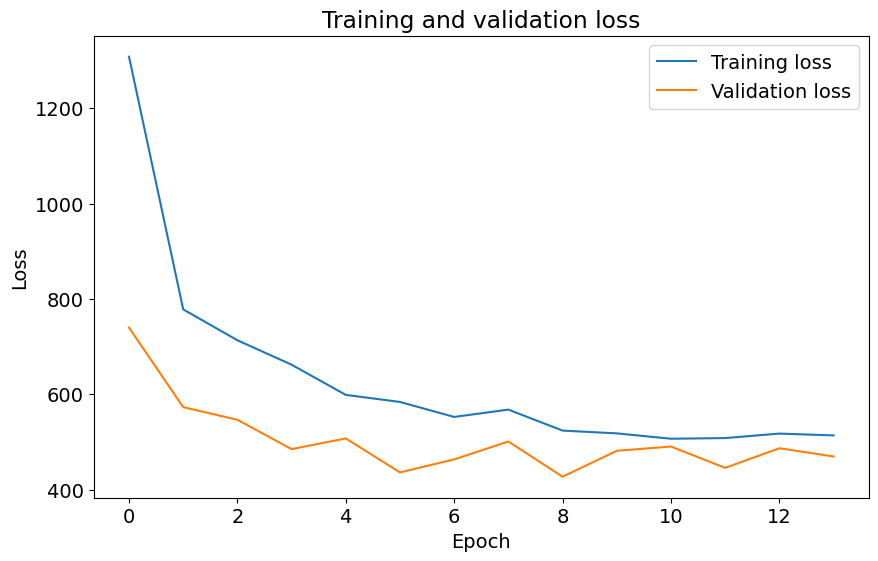

In [139]:
model35, mean_crps35, history35, predicted_means_std35 = process_model(model35, X_train=X_train_num, X_valid=X_valid_num, X_test=X_test_num, epochs = 200, loss_function=crps_normal_cost_function_v2)

In [140]:
X_train_num, X_valid_num, X_test_num = add_column(X_train_num, X_valid_num, X_test_num, X_train, X_valid, X_test, 'is_workday')

In [141]:
X_valid_num.head()

,season,day_of_week,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,school_holiday_indicator,public_holiday_indicator,holiday_indicator,is_workday
0,3,6,-0.598314,0.671661,0.219033,0.532297,0.294482,-0.397192,-0.711374,0.767902,0,1,0,1,0
1,3,0,-0.121137,-0.023976,2.264278,0.783166,1.320575,-0.345709,-1.065865,2.123101,1,1,0,1,1
2,3,1,-0.392344,1.301047,1.527366,0.993573,-0.958363,10.002447,-1.094803,1.432717,1,1,0,1,1
3,3,2,-1.117271,-0.044680,1.805269,0.969295,1.270619,-0.165517,-0.479869,1.125879,1,1,0,1,1
4,3,3,-1.243345,0.998776,-0.005788,0.483741,-0.028579,-0.397192,-0.913940,-0.485017,0,1,1,1,0


### Dropping the season column

In [142]:
X_train_num = X_train_num.drop(columns=['season'])
X_valid_num = X_valid_num.drop(columns=['season'])
X_test_num = X_test_num.drop(columns=['season'])

In [143]:
model36 = build_baseline_model(X_train_num.shape[1])

c:\Users\aisti\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



    Mean CRPS for baseline model with all predictors (except one-hot encoded holiday data): 397.22
    Columns in baseline model:
    'temperature', 'humidity', 'windspeed', 'wind_direction', 'visibility',
    'precipitation', 'sun', 'windspeed_max', 'precip_indic',
    'school_holiday_indicator', 'public_holiday_indicator',
    'holiday_indicator', 'is_workday', 'season', 'day_of_week'
    


Model information:

Callbacks: EarlyStopping (patience: 5), Learning Rate (Reduce on Plateau, patience: 5)
Batch size: 10
Epochs: 200

Epoch 1/200


317/317 ━━━━━━━━━━━━━━━━━━━━ 18s 27ms/step - loss: 1824.8035 - val_loss: 536.2620 - learning_rate: 0.0010
Epoch 2/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 773.9935 - val_loss: 548.4523 - learning_rate: 0.0010
Epoch 3/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 799.6529 - val_loss: 521.7626 - learning_rate: 0.0010
Epoch 4/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 721.4355 - val_loss: 503.4431 - learning_rate: 0.0010
Epoch 5/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 699.0552 - val_loss: 496.4370 - learning_rate: 0.0010
Epoch 6/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 642.6702 - val_loss: 538.3610 - learning_rate: 0.0010
Epoch 7/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 625.7979 - val_loss: 491.1890 - learning_rate: 0.0010
Epoch 8/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 614.9656 - val_loss: 417.3696 - learning_rate: 0.0010
Epoch 9/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - loss: 591.2299 - val_loss:

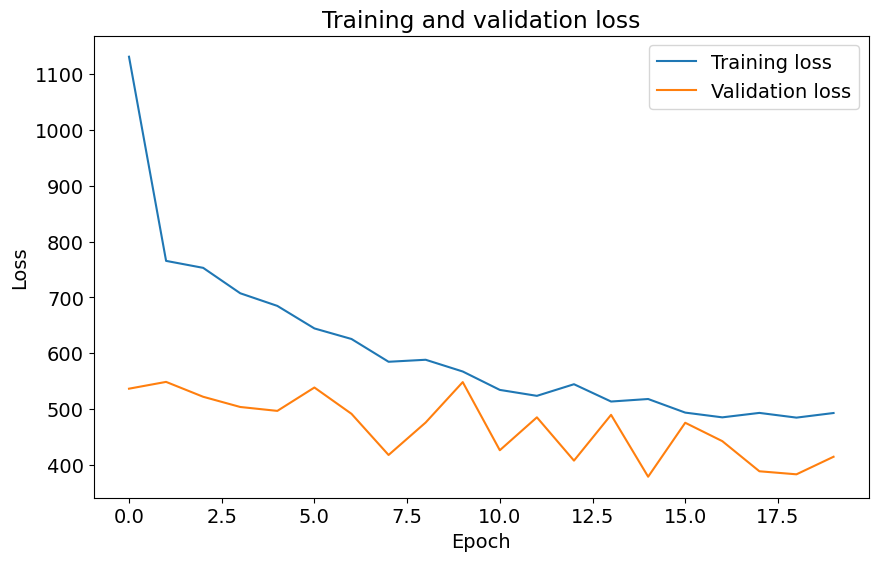

In [144]:
model36, mean_crps36, history36, predicted_means_std36 = process_model(model36, X_train=X_train_num, X_valid=X_valid_num, X_test=X_test_num, epochs = 200)

In [145]:
model37 = build_baseline_model2(X_train_num.shape[1])

Mean CRPS for baseline model with all predictors (except one-hot encoded holiday data): 342.76, loss function v2 used


c:\Users\aisti\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model information:

Callbacks: EarlyStopping (patience: 5), Learning Rate (Reduce on Plateau, patience: 5)
Batch size: 10
Epochs: 200

Epoch 1/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 1871.5073 - val_loss: 653.4182 - learning_rate: 0.0010
Epoch 2/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 751.3592 - val_loss: 544.0210 - learning_rate: 0.0010
Epoch 3/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 698.4094 - val_loss: 603.7270 - learning_rate: 0.0010
Epoch 4/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 674.2469 - val_loss: 511.7524 - learning_rate: 0.0010
Epoch 5/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 654.4261 - val_loss: 575.0955 - learning_rate: 0.0010
Epoch 6/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 611.0354 - val_loss: 484.1414 - learning_rate: 0.0010
Epoch 7/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 643.5380 - val_loss: 439.5062 - learning_rate: 0.0010
Epoch 8/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - los

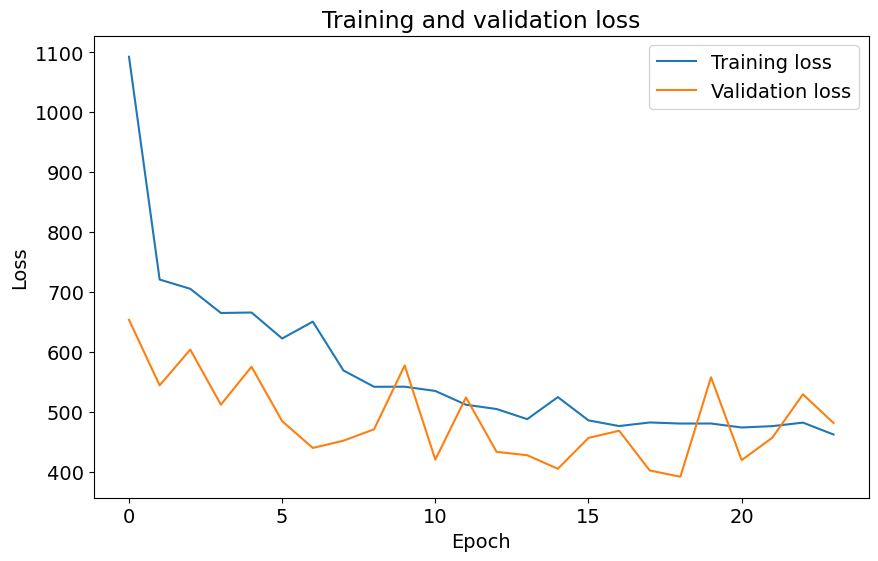

In [146]:
model37, mean_crps37, history37, predicted_means_std37 = process_model(model37, X_train=X_train_num, X_valid=X_valid_num, X_test=X_test_num, epochs = 200, loss_function=crps_normal_cost_function_v2)

In [147]:
X_train_num, X_valid_num, X_test_num = add_column(X_train_num, X_valid_num, X_test_num, X_train, X_valid, X_test, 'season')

In [148]:
X_test_num.head()

,day_of_week,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,school_holiday_indicator,public_holiday_indicator,holiday_indicator,is_workday,season
0,6,0.156666,-0.574689,-0.146301,0.435186,1.740197,-0.397192,-0.385820,0.154228,0,1,1,1,0,3
1,0,-0.267002,0.406656,-0.196261,0.386631,1.259373,0.014675,-0.736694,0.819042,1,1,0,1,1,3
2,1,-0.832871,1.040183,-1.011237,0.313798,0.940566,-0.397192,0.160386,-0.996413,0,1,0,1,1,3
3,2,-0.452449,0.216184,3.104234,0.726518,1.005769,-0.319967,-1.094803,1.995252,1,1,0,1,1,3
4,3,-0.179777,0.572284,1.486773,0.807444,0.600781,-0.319967,-1.015223,1.253728,1,1,0,1,1,3


### Dropping the weekday column

In [149]:
X_train_num = X_train_num.drop(columns=['day_of_week'])
X_valid_num = X_valid_num.drop(columns=['day_of_week'])
X_test_num = X_test_num.drop(columns=['day_of_week'])

In [150]:
model38 = build_baseline_model(X_train_num.shape[1])

c:\Users\aisti\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



    Mean CRPS for baseline model with all predictors (except one-hot encoded holiday data): 397.22
    Columns in baseline model:
    'temperature', 'humidity', 'windspeed', 'wind_direction', 'visibility',
    'precipitation', 'sun', 'windspeed_max', 'precip_indic',
    'school_holiday_indicator', 'public_holiday_indicator',
    'holiday_indicator', 'is_workday', 'season', 'day_of_week'
    


Model information:

Callbacks: EarlyStopping (patience: 5), Learning Rate (Reduce on Plateau, patience: 5)
Batch size: 10
Epochs: 200

Epoch 1/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 13s 14ms/step - loss: 1845.5365 - val_loss: 555.0020 - learning_rate: 0.0010
Epoch 2/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 757.4130 - val_loss: 585.0045 - learning_rate: 0.0010
Epoch 3/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 754.4121 - val_loss: 594.3071 - learning_rate: 0.0010
Epoch 4/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 719.3040 - val_loss: 568.3875 - learning_rate: 0.0010
Epoch 5/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 727.6368 - val_loss: 629.2281 - learning_rate: 0.0010
Epoch 6/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 712.6971 - val_loss: 795.2984 - learning_rate: 0.0010
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step

Mean CRPS: 507.71204426779786


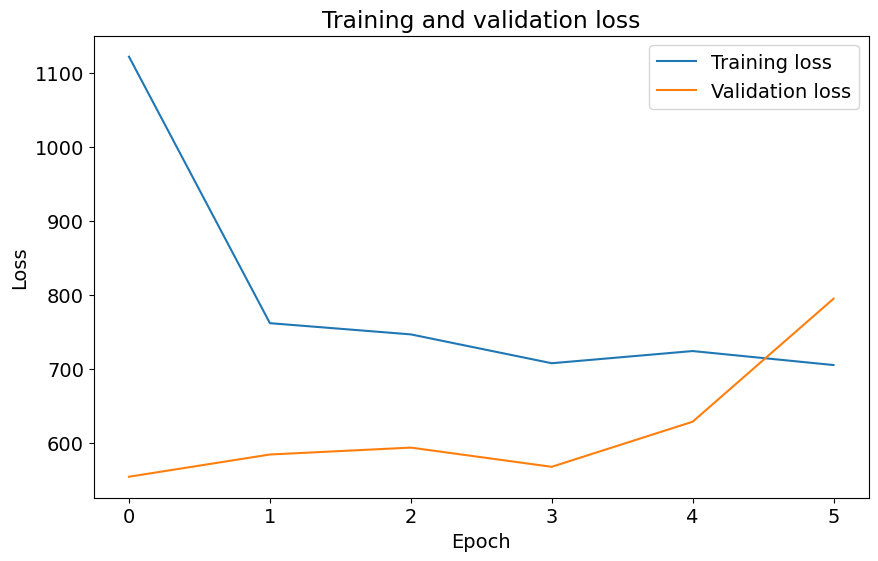

In [151]:
model38, mean_crps38, history38, predicted_means_std38 = process_model(model38, X_train=X_train_num, X_valid=X_valid_num, X_test=X_test_num, epochs = 200)

In [152]:
model39 = build_baseline_model2(X_train_num.shape[1])

Mean CRPS for baseline model with all predictors (except one-hot encoded holiday data): 342.76, loss function v2 used


c:\Users\aisti\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model information:

Callbacks: EarlyStopping (patience: 5), Learning Rate (Reduce on Plateau, patience: 5)
Batch size: 10
Epochs: 200

Epoch 1/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 12s 12ms/step - loss: 1837.4089 - val_loss: 552.8313 - learning_rate: 0.0010
Epoch 2/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 727.1010 - val_loss: 584.5908 - learning_rate: 0.0010
Epoch 3/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 679.8997 - val_loss: 502.4905 - learning_rate: 0.0010
Epoch 4/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 691.7978 - val_loss: 647.7247 - learning_rate: 0.0010
Epoch 5/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 688.8314 - val_loss: 563.5961 - learning_rate: 0.0010
Epoch 6/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 656.0635 - val_loss: 545.6990 - learning_rate: 0.0010
Epoch 7/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 666.2202 - val_loss: 483.6955 - learning_rate: 0.0010
Epoch 8/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - lo

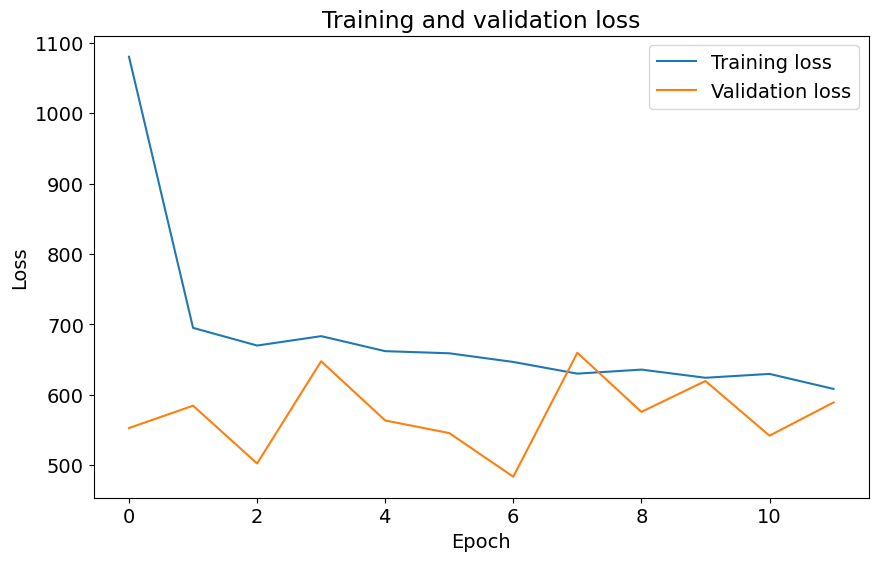

In [153]:
model39, mean_crps39, history39, predicted_means_std39 = process_model(model39, X_train=X_train_num, X_valid=X_valid_num, X_test=X_test_num, epochs = 200, loss_function=crps_normal_cost_function_v2)

In [154]:
X_train_num, X_valid_num, X_test_num = add_column(X_train_num, X_valid_num, X_test_num, X_train, X_valid, X_test, 'day_of_week')

In [155]:
X_test.columns

Index(['date', 'temperature', 'humidity', 'windspeed', 'wind_direction',
       'visibility', 'precipitation', 'sun', 'windspeed_max', 'precip_indic',
       'school_holiday', 'school_holiday_indicator', 'public_holiday',
       'public_holiday_indicator', 'holiday_indicator', 'is_workday', 'season',
       'day_of_week'],
      dtype='object')

In [156]:
X_test_num.columns

Index(['temperature', 'humidity', 'windspeed', 'wind_direction', 'visibility',
       'precipitation', 'sun', 'windspeed_max', 'precip_indic',
       'school_holiday_indicator', 'public_holiday_indicator',
       'holiday_indicator', 'is_workday', 'season', 'day_of_week'],
      dtype='object')

In [157]:
X_train_num.head()

,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,school_holiday_indicator,public_holiday_indicator,holiday_indicator,is_workday,season,day_of_week
0,-0.039776,-0.645081,-0.218119,0.079113,1.461434,-0.397192,-0.031329,0.665623,0,0,0,0,1,0,2
1,0.244625,-0.607815,-0.324284,1.042128,1.392951,-0.397192,-0.458165,0.154228,0,0,0,0,1,0,3
2,0.381694,-0.417343,-1.076810,0.831722,0.906360,-0.371451,0.254435,-1.124262,1,0,0,0,1,0,4
3,1.300863,-1.551894,-0.405469,-0.349793,0.675680,-0.397192,1.357699,-0.357168,0,0,0,0,0,0,5
4,0.745990,-0.897664,0.297096,0.532297,1.407369,0.555250,0.059103,1.688415,1,0,0,0,0,0,6


In [158]:
X_train.head()

,date,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,school_holiday,school_holiday_indicator,public_holiday,public_holiday_indicator,holiday_indicator,is_workday,season,day_of_week
0,2012-04-25,-0.039776,-0.645081,-0.218119,0.079113,1.461434,-0.397192,-0.031329,0.665623,0,No Holiday,0,No Holiday,0,0,1,0,2
1,2012-04-26,0.244625,-0.607815,-0.324284,1.042128,1.392951,-0.397192,-0.458165,0.154228,0,No Holiday,0,No Holiday,0,0,1,0,3
2,2012-04-27,0.381694,-0.417343,-1.076810,0.831722,0.906360,-0.371451,0.254435,-1.124262,1,No Holiday,0,No Holiday,0,0,1,0,4
3,2012-04-28,1.300863,-1.551894,-0.405469,-0.349793,0.675680,-0.397192,1.357699,-0.357168,0,No Holiday,0,No Holiday,0,0,0,0,5
4,2012-04-29,0.745990,-0.897664,0.297096,0.532297,1.407369,0.555250,0.059103,1.688415,1,No Holiday,0,No Holiday,0,0,0,0,6


### One Hot Encoding

One hot encoding the holiday information

#### Setup

In [159]:
def enc_holidays(X_train, X_train_num, X_valid, X_valid_num, X_test, X_test_num, encoder, col_name):
    
    #store existing column names
    cols_existing = list(X_train_num.columns)
    
    #fit encoder to X_train
    encoder.fit(X_train[[col_name]])
    print('Encoder categories: ' + str(encoder.categories_))
    
    #transform data from X_train[holiday] and add to X_train_num
    df_encoder = pd.DataFrame(encoder.transform(X_train[[col_name]]).toarray())
    X_train_num = pd.concat([X_train_num, df_encoder], axis=1)
    
    #transform data from X_valid[holiday] and add to X_valid_num
    df_encoder = pd.DataFrame(encoder.transform(X_valid[[col_name]]).toarray())
    X_valid_num = pd.concat([X_valid_num, df_encoder], axis=1)
    
    #transform data from X_test[holiday] and add to X_test_num
    df_encoder = pd.DataFrame(encoder.transform(X_test[[col_name]]).toarray())
    X_test_num = pd.concat([X_test_num, df_encoder], axis=1)
    
    #store added column names from encoder categories
    cols_new = encoder.categories_[0].tolist()
    
    #combine columns
    cols_all = cols_existing + cols_new

    #rename columns for better overview
    X_train_num.columns = cols_all
    X_valid_num.columns = cols_all
    X_test_num.columns = cols_all
    
    return X_train, X_train_num, X_valid, X_valid_num, X_test, X_test_num

In [160]:
enc_school_holiday = OneHotEncoder(handle_unknown='ignore')

#### Encoding the school holiday column

In [161]:
X_train, X_train_num, X_valid, X_valid_num, X_test, X_test_num = enc_holidays(X_train, X_train_num, X_valid, X_valid_num, X_test, X_test_num, enc_school_holiday, 'school_holiday')

Encoder categories: [array(['No Holiday', 'herbstferien', 'osterferien', 'pfingstferien',
       'sommerferien', 'weihnachtsferien'], dtype=object)]


In [162]:
X_train_num.head()

,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,school_holiday_indicator,...,holiday_indicator,is_workday,season,day_of_week,No Holiday,herbstferien,osterferien,pfingstferien,sommerferien,weihnachtsferien
0,-0.039776,-0.645081,-0.218119,0.079113,1.461434,-0.397192,-0.031329,0.665623,0,0,...,0,1,0,2,1.0,0.0,0.0,0.0,0.0,0.0
1,0.244625,-0.607815,-0.324284,1.042128,1.392951,-0.397192,-0.458165,0.154228,0,0,...,0,1,0,3,1.0,0.0,0.0,0.0,0.0,0.0
2,0.381694,-0.417343,-1.076810,0.831722,0.906360,-0.371451,0.254435,-1.124262,1,0,...,0,1,0,4,1.0,0.0,0.0,0.0,0.0,0.0
3,1.300863,-1.551894,-0.405469,-0.349793,0.675680,-0.397192,1.357699,-0.357168,0,0,...,0,0,0,5,1.0,0.0,0.0,0.0,0.0,0.0
4,0.745990,-0.897664,0.297096,0.532297,1.407369,0.555250,0.059103,1.688415,1,0,...,0,0,0,6,1.0,0.0,0.0,0.0,0.0,0.0


In [163]:
X_train.tail()

,date,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,school_holiday,school_holiday_indicator,public_holiday,public_holiday_indicator,holiday_indicator,is_workday,season,day_of_week
3156,2021-12-28,-0.335171,0.737912,1.546101,0.564667,0.519395,2.872001,-1.094803,2.915764,1,weihnachtsferien,1,No Holiday,0,1,1,3,1
3157,2021-12-29,-0.389412,1.284484,1.183889,0.807444,0.235983,0.297833,-1.094803,0.972461,1,weihnachtsferien,1,No Holiday,0,1,1,3,2
3158,2021-12-30,0.183053,1.135419,1.211992,0.734611,1.887147,-0.319967,-1.087569,0.435495,1,weihnachtsferien,1,No Holiday,0,1,1,3,3
3159,2021-12-31,-0.530879,1.574333,-0.599065,0.548482,-0.621426,-0.397192,-0.190488,-0.331598,0,weihnachtsferien,1,No Holiday,0,1,1,3,4
3160,2022-01-01,-0.453182,1.052605,-1.151750,0.427093,-0.402028,-0.397192,0.178472,-1.252111,0,weihnachtsferien,1,Neujahr,1,1,0,3,5


In [164]:
model40 = build_baseline_model(X_train_num.shape[1])

c:\Users\aisti\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



    Mean CRPS for baseline model with all predictors (except one-hot encoded holiday data): 397.22
    Columns in baseline model:
    'temperature', 'humidity', 'windspeed', 'wind_direction', 'visibility',
    'precipitation', 'sun', 'windspeed_max', 'precip_indic',
    'school_holiday_indicator', 'public_holiday_indicator',
    'holiday_indicator', 'is_workday', 'season', 'day_of_week'
    


Model information:

Callbacks: EarlyStopping (patience: 5), Learning Rate (Reduce on Plateau, patience: 5)
Batch size: 10
Epochs: 200

Epoch 1/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 1954.4385 - val_loss: 541.4001 - learning_rate: 0.0010
Epoch 2/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 738.1827 - val_loss: 503.4033 - learning_rate: 0.0010
Epoch 3/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 704.0793 - val_loss: 482.0361 - learning_rate: 0.0010
Epoch 4/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 704.6042 - val_loss: 526.1526 - learning_rate: 0.0010
Epoch 5/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 666.6356 - val_loss: 484.2397 - learning_rate: 0.0010
Epoch 6/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 609.7425 - val_loss: 607.1605 - learning_rate: 0.0010
Epoch 7/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - loss: 614.7712 - val_loss: 471.2529 - learning_rate: 0.0010
Epoch 8/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step -

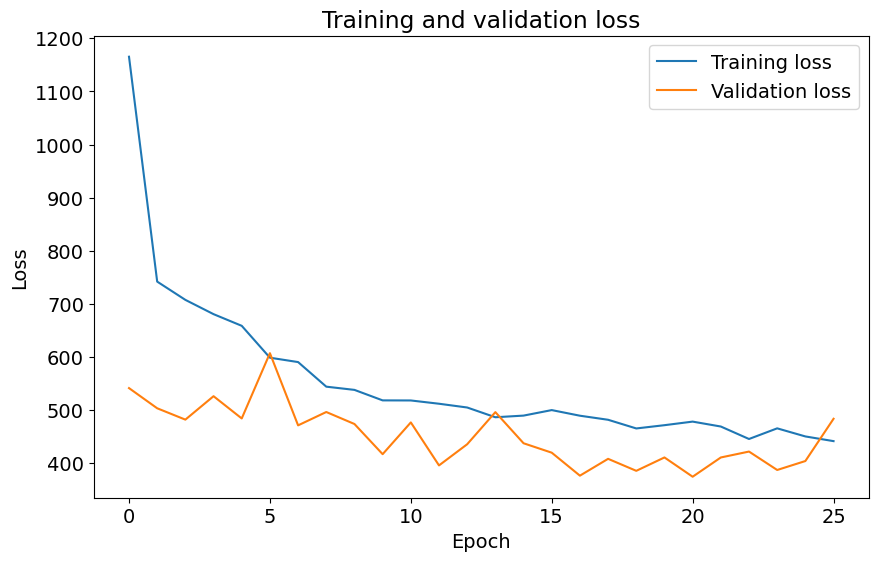

In [165]:
model40, mean_crps40, history40, predicted_means_std40 = process_model(model40, X_train=X_train_num, X_valid=X_valid_num, X_test=X_test_num, epochs = 200)

In [166]:
model40a = build_baseline_model2(X_train_num.shape[1])

Mean CRPS for baseline model with all predictors (except one-hot encoded holiday data): 342.76, loss function v2 used


c:\Users\aisti\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model information:

Callbacks: EarlyStopping (patience: 5), Learning Rate (Reduce on Plateau, patience: 5)
Batch size: 10
Epochs: 200

Epoch 1/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 1868.9829 - val_loss: 484.6538 - learning_rate: 0.0010
Epoch 2/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 681.5633 - val_loss: 492.4836 - learning_rate: 0.0010
Epoch 3/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 638.5916 - val_loss: 462.9294 - learning_rate: 0.0010
Epoch 4/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 646.5002 - val_loss: 455.5937 - learning_rate: 0.0010
Epoch 5/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 578.9799 - val_loss: 476.7985 - learning_rate: 0.0010
Epoch 6/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 552.8748 - val_loss: 537.8765 - learning_rate: 0.0010
Epoch 7/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 548.6858 - val_loss: 448.8068 - learning_rate: 0.0010
Epoch 8/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss

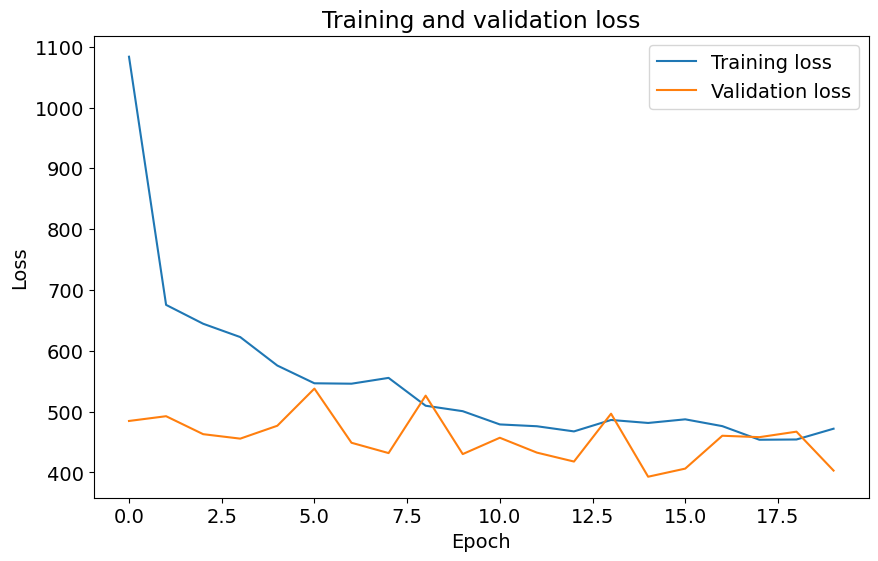

In [167]:
model40a, mean_crps40a, history40a, predicted_means_std40a = process_model(model40a, X_train=X_train_num, X_valid=X_valid_num, X_test=X_test_num, epochs = 200, loss_function=crps_normal_cost_function_v2)

In [168]:
col_school_holiday_enc = enc_school_holiday.categories_[0].tolist()

In [169]:
col_school_holiday_enc

['No Holiday',
 'herbstferien',
 'osterferien',
 'pfingstferien',
 'sommerferien',
 'weihnachtsferien']

In [170]:
X_train_num_school_holiday_enc = X_train_num[col_school_holiday_enc].copy()
X_valid_num_school_holiday_enc = X_valid_num[col_school_holiday_enc].copy()
X_test_num_school_holiday_enc = X_test_num[col_school_holiday_enc].copy()

In [171]:
X_train_num_school_holiday_enc.tail()

,No Holiday,herbstferien,osterferien,pfingstferien,sommerferien,weihnachtsferien
3156,0.0,0.0,0.0,0.0,0.0,1.0
3157,0.0,0.0,0.0,0.0,0.0,1.0
3158,0.0,0.0,0.0,0.0,0.0,1.0
3159,0.0,0.0,0.0,0.0,0.0,1.0
3160,0.0,0.0,0.0,0.0,0.0,1.0


In [172]:
X_train_num = X_train_num.drop(columns=col_school_holiday_enc)
X_valid_num = X_valid_num.drop(columns=col_school_holiday_enc)
X_test_num = X_test_num.drop(columns=col_school_holiday_enc)

In [173]:
X_train_num.tail()

,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,school_holiday_indicator,public_holiday_indicator,holiday_indicator,is_workday,season,day_of_week
3156,-0.335171,0.737912,1.546101,0.564667,0.519395,2.872001,-1.094803,2.915764,1,1,0,1,1,3,1
3157,-0.389412,1.284484,1.183889,0.807444,0.235983,0.297833,-1.094803,0.972461,1,1,0,1,1,3,2
3158,0.183053,1.135419,1.211992,0.734611,1.887147,-0.319967,-1.087569,0.435495,1,1,0,1,1,3,3
3159,-0.530879,1.574333,-0.599065,0.548482,-0.621426,-0.397192,-0.190488,-0.331598,0,1,0,1,1,3,4
3160,-0.453182,1.052605,-1.151750,0.427093,-0.402028,-0.397192,0.178472,-1.252111,0,1,1,1,0,3,5


In [174]:
enc_public_holiday = OneHotEncoder(handle_unknown='ignore')

#### Encoding the public holiday column

In [175]:
X_train, X_train_num, X_valid, X_valid_num, X_test, X_test_num = enc_holidays(X_train, X_train_num, X_valid, X_valid_num, X_test, X_test_num, enc_public_holiday, 'public_holiday')

Encoder categories: [array(['Allerheiligen', 'Christi Himmelfahrt', 'Fronleichnam',
       'Heilige Drei Koenige', 'Karfreitag', 'Neujahr', 'No Holiday',
       'Ostermontag', 'Pfingstmontag', 'Reformationstag',
       'Tag der Arbeit', 'Tag der Deutschen Einheit', 'Weihnachten'],
      dtype=object)]


In [176]:
X_test_num.head()

,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,school_holiday_indicator,...,Heilige Drei Koenige,Karfreitag,Neujahr,No Holiday,Ostermontag,Pfingstmontag,Reformationstag,Tag der Arbeit,Tag der Deutschen Einheit,Weihnachten
0,0.156666,-0.574689,-0.146301,0.435186,1.740197,-0.397192,-0.385820,0.154228,0,1,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.267002,0.406656,-0.196261,0.386631,1.259373,0.014675,-0.736694,0.819042,1,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.832871,1.040183,-1.011237,0.313798,0.940566,-0.397192,0.160386,-0.996413,0,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.452449,0.216184,3.104234,0.726518,1.005769,-0.319967,-1.094803,1.995252,1,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.179777,0.572284,1.486773,0.807444,0.600781,-0.319967,-1.015223,1.253728,1,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [177]:
X_test.head()

,date,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,school_holiday,school_holiday_indicator,public_holiday,public_holiday_indicator,holiday_indicator,is_workday,season,day_of_week
0,2023-01-01,0.156666,-0.574689,-0.146301,0.435186,1.740197,-0.397192,-0.385820,0.154228,0,weihnachtsferien,1,Neujahr,1,1,0,3,6
1,2023-01-02,-0.267002,0.406656,-0.196261,0.386631,1.259373,0.014675,-0.736694,0.819042,1,weihnachtsferien,1,No Holiday,0,1,1,3,0
2,2023-01-03,-0.832871,1.040183,-1.011237,0.313798,0.940566,-0.397192,0.160386,-0.996413,0,weihnachtsferien,1,No Holiday,0,1,1,3,1
3,2023-01-04,-0.452449,0.216184,3.104234,0.726518,1.005769,-0.319967,-1.094803,1.995252,1,weihnachtsferien,1,No Holiday,0,1,1,3,2
4,2023-01-05,-0.179777,0.572284,1.486773,0.807444,0.600781,-0.319967,-1.015223,1.253728,1,weihnachtsferien,1,No Holiday,0,1,1,3,3


In [178]:
model41 = build_baseline_model(X_train_num.shape[1])


    Mean CRPS for baseline model with all predictors (except one-hot encoded holiday data): 397.22
    Columns in baseline model:
    'temperature', 'humidity', 'windspeed', 'wind_direction', 'visibility',
    'precipitation', 'sun', 'windspeed_max', 'precip_indic',
    'school_holiday_indicator', 'public_holiday_indicator',
    'holiday_indicator', 'is_workday', 'season', 'day_of_week'
    


c:\Users\aisti\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model information:

Callbacks: EarlyStopping (patience: 5), Learning Rate (Reduce on Plateau, patience: 5)
Batch size: 10
Epochs: 200

Epoch 1/200


317/317 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 1828.8741 - val_loss: 757.0323 - learning_rate: 0.0010
Epoch 2/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 762.6592 - val_loss: 521.8016 - learning_rate: 0.0010
Epoch 3/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 716.2181 - val_loss: 487.9069 - learning_rate: 0.0010
Epoch 4/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 665.4551 - val_loss: 474.3033 - learning_rate: 0.0010
Epoch 5/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 624.8265 - val_loss: 469.3120 - learning_rate: 0.0010
Epoch 6/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 606.1529 - val_loss: 509.3253 - learning_rate: 0.0010
Epoch 7/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 605.9938 - val_loss: 439.8884 - learning_rate: 0.0010
Epoch 8/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 557.5456 - val_loss: 438.8672 - learning_rate: 0.0010
Epoch 9/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 553.5475 - val_loss: 453.1965 

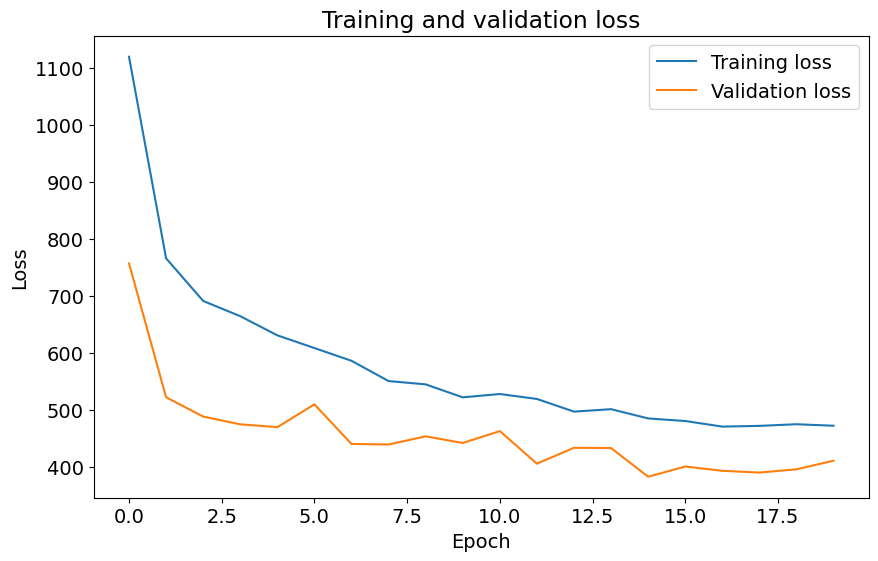

In [179]:
model41, mean_crps41, history41, predicted_means_std41 = process_model(model41, X_train=X_train_num, X_valid=X_valid_num, X_test=X_test_num, epochs = 200)

In [180]:
model41a = build_baseline_model2(X_train_num.shape[1])

c:\Users\aisti\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Mean CRPS for baseline model with all predictors (except one-hot encoded holiday data): 342.76, loss function v2 used


Model information:

Callbacks: EarlyStopping (patience: 5), Learning Rate (Reduce on Plateau, patience: 5)
Batch size: 10
Epochs: 200

Epoch 1/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - loss: 1842.6737 - val_loss: 610.7784 - learning_rate: 0.0010
Epoch 2/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 734.2796 - val_loss: 567.4713 - learning_rate: 0.0010
Epoch 3/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 710.3748 - val_loss: 456.9774 - learning_rate: 0.0010
Epoch 4/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 614.6100 - val_loss: 526.9224 - learning_rate: 0.0010
Epoch 5/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 648.0660 - val_loss: 521.5428 - learning_rate: 0.0010
Epoch 6/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 584.5987 - val_loss: 477.4605 - learning_rate: 0.0010
Epoch 7/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 556.9832 - val_loss: 576.9851 - learning_rate: 0.0010
Epoch 8/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - l

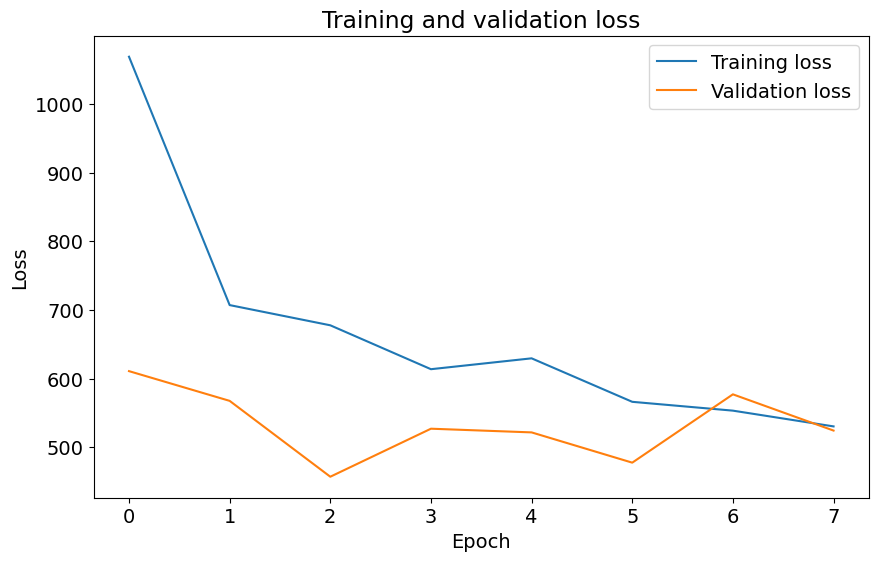

In [181]:
model41a, mean_crps41a, history41a, predicted_means_std41a = process_model(model41a, X_train=X_train_num, X_valid=X_valid_num, X_test=X_test_num, epochs = 200, loss_function=crps_normal_cost_function_v2)

In [182]:
col_public_holiday_enc = enc_public_holiday.categories_[0].tolist()
col_public_holiday_enc

['Allerheiligen',
 'Christi Himmelfahrt',
 'Fronleichnam',
 'Heilige Drei Koenige',
 'Karfreitag',
 'Neujahr',
 'No Holiday',
 'Ostermontag',
 'Pfingstmontag',
 'Reformationstag',
 'Tag der Arbeit',
 'Tag der Deutschen Einheit',
 'Weihnachten']

In [183]:
X_train_num_public_holiday_enc = X_train_num[col_public_holiday_enc].copy()
X_valid_num_public_holiday_enc = X_valid_num[col_public_holiday_enc].copy()
X_test_num_public_holiday_enc = X_test_num[col_public_holiday_enc].copy()

In [184]:
X_valid_num_public_holiday_enc.head()

,Allerheiligen,Christi Himmelfahrt,Fronleichnam,Heilige Drei Koenige,Karfreitag,Neujahr,No Holiday,Ostermontag,Pfingstmontag,Reformationstag,Tag der Arbeit,Tag der Deutschen Einheit,Weihnachten
0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [185]:
X_train_num = X_train_num.drop(columns=col_public_holiday_enc)
X_valid_num = X_valid_num.drop(columns=col_public_holiday_enc)
X_test_num = X_test_num.drop(columns=col_public_holiday_enc)

In [186]:
X_test_num.head()

,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,school_holiday_indicator,public_holiday_indicator,holiday_indicator,is_workday,season,day_of_week
0,0.156666,-0.574689,-0.146301,0.435186,1.740197,-0.397192,-0.385820,0.154228,0,1,1,1,0,3,6
1,-0.267002,0.406656,-0.196261,0.386631,1.259373,0.014675,-0.736694,0.819042,1,1,0,1,1,3,0
2,-0.832871,1.040183,-1.011237,0.313798,0.940566,-0.397192,0.160386,-0.996413,0,1,0,1,1,3,1
3,-0.452449,0.216184,3.104234,0.726518,1.005769,-0.319967,-1.094803,1.995252,1,1,0,1,1,3,2
4,-0.179777,0.572284,1.486773,0.807444,0.600781,-0.319967,-1.015223,1.253728,1,1,0,1,1,3,3


In [187]:
X_train_num.head()

,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,school_holiday_indicator,public_holiday_indicator,holiday_indicator,is_workday,season,day_of_week
0,-0.039776,-0.645081,-0.218119,0.079113,1.461434,-0.397192,-0.031329,0.665623,0,0,0,0,1,0,2
1,0.244625,-0.607815,-0.324284,1.042128,1.392951,-0.397192,-0.458165,0.154228,0,0,0,0,1,0,3
2,0.381694,-0.417343,-1.076810,0.831722,0.906360,-0.371451,0.254435,-1.124262,1,0,0,0,1,0,4
3,1.300863,-1.551894,-0.405469,-0.349793,0.675680,-0.397192,1.357699,-0.357168,0,0,0,0,0,0,5
4,0.745990,-0.897664,0.297096,0.532297,1.407369,0.555250,0.059103,1.688415,1,0,0,0,0,0,6


In [188]:
X_valid_num.head()

,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,school_holiday_indicator,public_holiday_indicator,holiday_indicator,is_workday,season,day_of_week
0,-0.598314,0.671661,0.219033,0.532297,0.294482,-0.397192,-0.711374,0.767902,0,1,0,1,0,3,6
1,-0.121137,-0.023976,2.264278,0.783166,1.320575,-0.345709,-1.065865,2.123101,1,1,0,1,1,3,0
2,-0.392344,1.301047,1.527366,0.993573,-0.958363,10.002447,-1.094803,1.432717,1,1,0,1,1,3,1
3,-1.117271,-0.044680,1.805269,0.969295,1.270619,-0.165517,-0.479869,1.125879,1,1,0,1,1,3,2
4,-1.243345,0.998776,-0.005788,0.483741,-0.028579,-0.397192,-0.913940,-0.485017,0,1,1,1,0,3,3


In [189]:
X_test_num.head()

,temperature,humidity,windspeed,wind_direction,visibility,precipitation,sun,windspeed_max,precip_indic,school_holiday_indicator,public_holiday_indicator,holiday_indicator,is_workday,season,day_of_week
0,0.156666,-0.574689,-0.146301,0.435186,1.740197,-0.397192,-0.385820,0.154228,0,1,1,1,0,3,6
1,-0.267002,0.406656,-0.196261,0.386631,1.259373,0.014675,-0.736694,0.819042,1,1,0,1,1,3,0
2,-0.832871,1.040183,-1.011237,0.313798,0.940566,-0.397192,0.160386,-0.996413,0,1,0,1,1,3,1
3,-0.452449,0.216184,3.104234,0.726518,1.005769,-0.319967,-1.094803,1.995252,1,1,0,1,1,3,2
4,-0.179777,0.572284,1.486773,0.807444,0.600781,-0.319967,-1.015223,1.253728,1,1,0,1,1,3,3


### Leaving out Feature Classes

Now i want to leave out classes of features, e.g. all the wind features

but first, a model with all predictors.

#### Baseline model

In [190]:
model42 = build_baseline_model(X_train_num.shape[1])


    Mean CRPS for baseline model with all predictors (except one-hot encoded holiday data): 397.22
    Columns in baseline model:
    'temperature', 'humidity', 'windspeed', 'wind_direction', 'visibility',
    'precipitation', 'sun', 'windspeed_max', 'precip_indic',
    'school_holiday_indicator', 'public_holiday_indicator',
    'holiday_indicator', 'is_workday', 'season', 'day_of_week'
    


c:\Users\aisti\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model information:

Callbacks: EarlyStopping (patience: 5), Learning Rate (Reduce on Plateau, patience: 5)
Batch size: 10
Epochs: 200

Epoch 1/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 1936.2332 - val_loss: 631.4966 - learning_rate: 0.0010
Epoch 2/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 805.7886 - val_loss: 595.7604 - learning_rate: 0.0010
Epoch 3/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 738.1106 - val_loss: 526.0400 - learning_rate: 0.0010
Epoch 4/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 731.4413 - val_loss: 484.0492 - learning_rate: 0.0010
Epoch 5/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 720.0656 - val_loss: 561.4324 - learning_rate: 0.0010
Epoch 6/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 641.8127 - val_loss: 524.2185 - learning_rate: 0.0010
Epoch 7/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 663.2914 - val_loss: 494.1927 - learning_rate: 0.0010
Epoch 8/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss

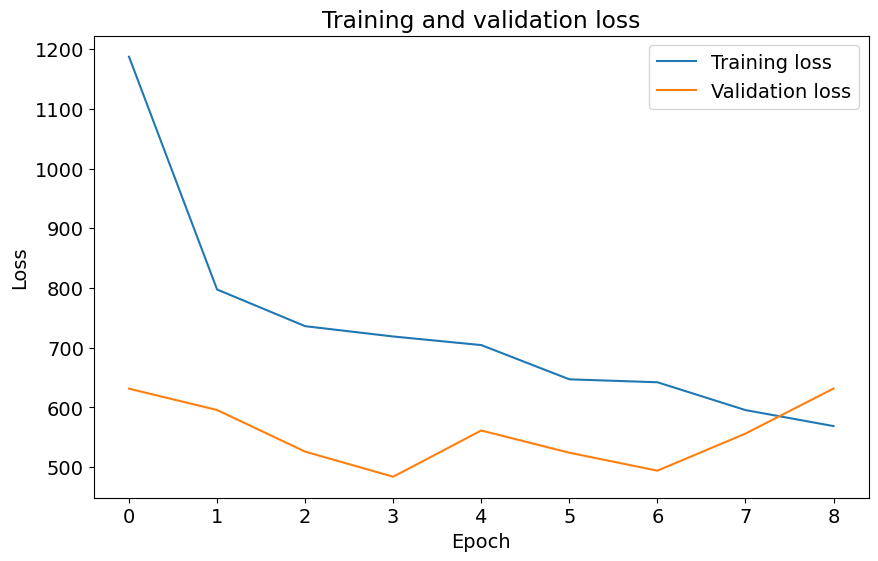

In [191]:
model42, mean_crps42, history42, predicted_means_std42 = process_model(model42, X_train=X_train_num, X_valid=X_valid_num, X_test=X_test_num, epochs = 200)

#### Dropping the wind features

In [192]:
col_wind = ['windspeed', 'wind_direction', 'windspeed_max']
X_train_num = X_train_num.drop(columns = col_wind)
X_valid_num = X_valid_num.drop(columns = col_wind)
X_test_num = X_test_num.drop(columns = col_wind)

In [193]:
X_train_num.head()

,temperature,humidity,visibility,precipitation,sun,precip_indic,school_holiday_indicator,public_holiday_indicator,holiday_indicator,is_workday,season,day_of_week
0,-0.039776,-0.645081,1.461434,-0.397192,-0.031329,0,0,0,0,1,0,2
1,0.244625,-0.607815,1.392951,-0.397192,-0.458165,0,0,0,0,1,0,3
2,0.381694,-0.417343,0.906360,-0.371451,0.254435,1,0,0,0,1,0,4
3,1.300863,-1.551894,0.675680,-0.397192,1.357699,0,0,0,0,0,0,5
4,0.745990,-0.897664,1.407369,0.555250,0.059103,1,0,0,0,0,0,6


In [194]:
model43 = build_baseline_model(X_train_num.shape[1])


    Mean CRPS for baseline model with all predictors (except one-hot encoded holiday data): 397.22
    Columns in baseline model:
    'temperature', 'humidity', 'windspeed', 'wind_direction', 'visibility',
    'precipitation', 'sun', 'windspeed_max', 'precip_indic',
    'school_holiday_indicator', 'public_holiday_indicator',
    'holiday_indicator', 'is_workday', 'season', 'day_of_week'
    


c:\Users\aisti\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model information:

Callbacks: EarlyStopping (patience: 5), Learning Rate (Reduce on Plateau, patience: 5)
Batch size: 10
Epochs: 200

Epoch 1/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 9s 9ms/step - loss: 1959.6704 - val_loss: 608.6290 - learning_rate: 0.0010
Epoch 2/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 801.6871 - val_loss: 778.1366 - learning_rate: 0.0010
Epoch 3/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 756.2814 - val_loss: 548.3815 - learning_rate: 0.0010
Epoch 4/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 715.4524 - val_loss: 487.4745 - learning_rate: 0.0010
Epoch 5/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 688.0181 - val_loss: 605.0001 - learning_rate: 0.0010
Epoch 6/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 655.0956 - val_loss: 559.3191 - learning_rate: 0.0010
Epoch 7/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 623.3664 - val_loss: 538.8334 - learning_rate: 0.0010
Epoch 8/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss

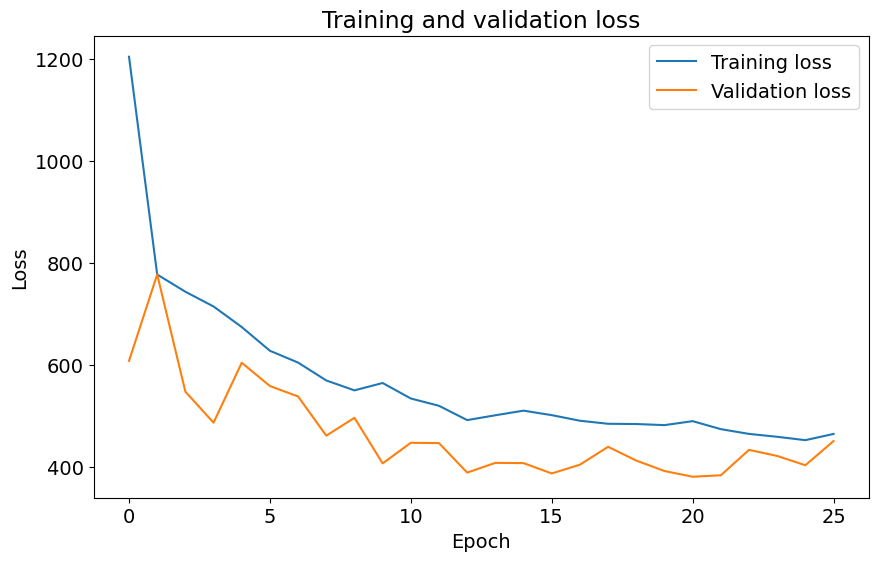

In [195]:
model43, mean_crps43, history43, predicted_means_std43 = process_model(model43, X_train=X_train_num, X_valid=X_valid_num, X_test=X_test_num, epochs = 200)

In [196]:
model43a = build_baseline_model2(X_train_num.shape[1])

Mean CRPS for baseline model with all predictors (except one-hot encoded holiday data): 342.76, loss function v2 used


c:\Users\aisti\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model information:

Callbacks: EarlyStopping (patience: 5), Learning Rate (Reduce on Plateau, patience: 5)
Batch size: 10
Epochs: 200

Epoch 1/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 1898.6638 - val_loss: 531.1039 - learning_rate: 0.0010
Epoch 2/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 727.4252 - val_loss: 630.0824 - learning_rate: 0.0010
Epoch 3/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 721.6504 - val_loss: 517.9099 - learning_rate: 0.0010
Epoch 4/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 674.1431 - val_loss: 485.7884 - learning_rate: 0.0010
Epoch 5/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 663.3019 - val_loss: 619.7287 - learning_rate: 0.0010
Epoch 6/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 613.2562 - val_loss: 519.5885 - learning_rate: 0.0010
Epoch 7/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 598.3680 - val_loss: 445.8851 - learning_rate: 0.0010
Epoch 8/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss

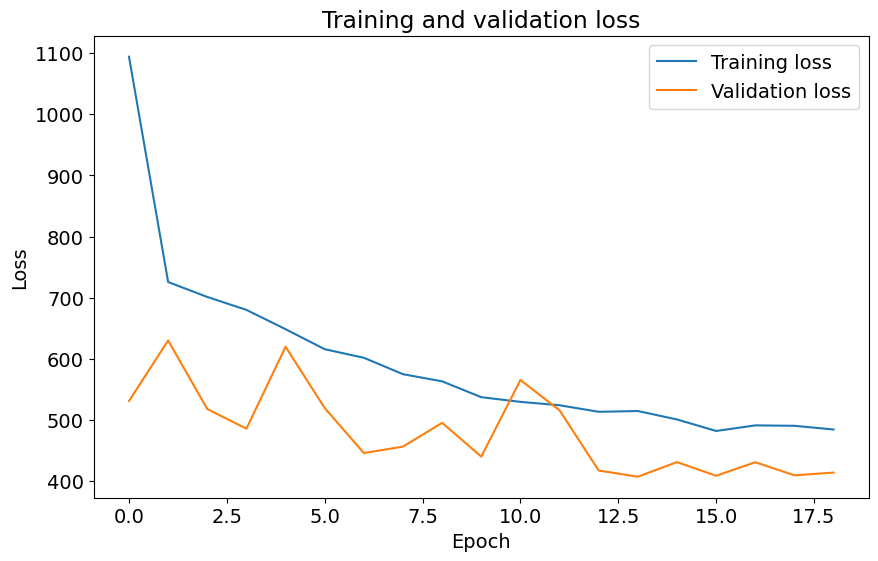

In [197]:
model43a = process_model(model43a, X_train=X_train_num, X_valid=X_valid_num, X_test=X_test_num, epochs = 200, loss_function=crps_normal_cost_function_v2)

In [198]:
X_train_num, X_valid_num, X_test_num = add_column(X_train_num, X_valid_num, X_test_num, X_train, X_valid, X_test, 'windspeed')
X_train_num, X_valid_num, X_test_num = add_column(X_train_num, X_valid_num, X_test_num, X_train, X_valid, X_test, 'wind_direction')
X_train_num, X_valid_num, X_test_num = add_column(X_train_num, X_valid_num, X_test_num, X_train, X_valid, X_test, 'windspeed_max')

In [199]:
X_valid_num.tail()

,temperature,humidity,visibility,precipitation,sun,precip_indic,school_holiday_indicator,public_holiday_indicator,holiday_indicator,is_workday,season,day_of_week,windspeed,wind_direction,windspeed_max
359,-1.064496,0.559862,1.588705,-0.397192,-0.353265,0,1,0,1,1,3,1,-0.258711,0.499927,-0.408308
360,-0.478837,-0.529141,2.515281,-0.397192,-0.823509,0,1,0,1,1,3,2,1.087091,0.637500,0.563344
361,-0.104279,-0.185464,2.110005,0.143383,-0.913940,1,1,0,1,1,3,3,2.276769,0.637500,1.739554
362,-0.691404,1.127138,0.451524,0.169125,-0.508807,1,1,0,1,1,3,4,-0.674006,0.265242,1.739554
363,0.541485,-0.727895,2.650446,-0.397192,-0.201340,0,1,0,1,0,3,5,1.564836,0.597037,1.458287


#### Dropping the holiday features

In [200]:
X_test_num.columns

Index(['temperature', 'humidity', 'visibility', 'precipitation', 'sun',
       'precip_indic', 'school_holiday_indicator', 'public_holiday_indicator',
       'holiday_indicator', 'is_workday', 'season', 'day_of_week', 'windspeed',
       'wind_direction', 'windspeed_max'],
      dtype='object')

In [201]:
col_holiday = ['school_holiday_indicator', 'public_holiday_indicator',
       'holiday_indicator']
X_train_num = X_train_num.drop(columns = col_holiday)
X_valid_num = X_valid_num.drop(columns = col_holiday)
X_test_num = X_test_num.drop(columns = col_holiday)

In [202]:
X_valid_num.head()

,temperature,humidity,visibility,precipitation,sun,precip_indic,is_workday,season,day_of_week,windspeed,wind_direction,windspeed_max
0,-0.598314,0.671661,0.294482,-0.397192,-0.711374,0,0,3,6,0.219033,0.532297,0.767902
1,-0.121137,-0.023976,1.320575,-0.345709,-1.065865,1,1,3,0,2.264278,0.783166,2.123101
2,-0.392344,1.301047,-0.958363,10.002447,-1.094803,1,1,3,1,1.527366,0.993573,1.432717
3,-1.117271,-0.044680,1.270619,-0.165517,-0.479869,1,1,3,2,1.805269,0.969295,1.125879
4,-1.243345,0.998776,-0.028579,-0.397192,-0.913940,0,0,3,3,-0.005788,0.483741,-0.485017


In [203]:
model44 = build_baseline_model(X_train_num.shape[1])


    Mean CRPS for baseline model with all predictors (except one-hot encoded holiday data): 397.22
    Columns in baseline model:
    'temperature', 'humidity', 'windspeed', 'wind_direction', 'visibility',
    'precipitation', 'sun', 'windspeed_max', 'precip_indic',
    'school_holiday_indicator', 'public_holiday_indicator',
    'holiday_indicator', 'is_workday', 'season', 'day_of_week'
    


c:\Users\aisti\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model information:

Callbacks: EarlyStopping (patience: 5), Learning Rate (Reduce on Plateau, patience: 5)
Batch size: 10
Epochs: 200

Epoch 1/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 1979.4042 - val_loss: 606.0800 - learning_rate: 0.0010
Epoch 2/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 803.7623 - val_loss: 586.0836 - learning_rate: 0.0010
Epoch 3/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 766.8969 - val_loss: 1011.6388 - learning_rate: 0.0010
Epoch 4/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 837.9870 - val_loss: 638.9170 - learning_rate: 0.0010
Epoch 5/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 739.5997 - val_loss: 585.8114 - learning_rate: 0.0010
Epoch 6/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 726.9686 - val_loss: 522.1784 - learning_rate: 0.0010
Epoch 7/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 693.8962 - val_loss: 557.4103 - learning_rate: 0.0010
Epoch 8/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - los

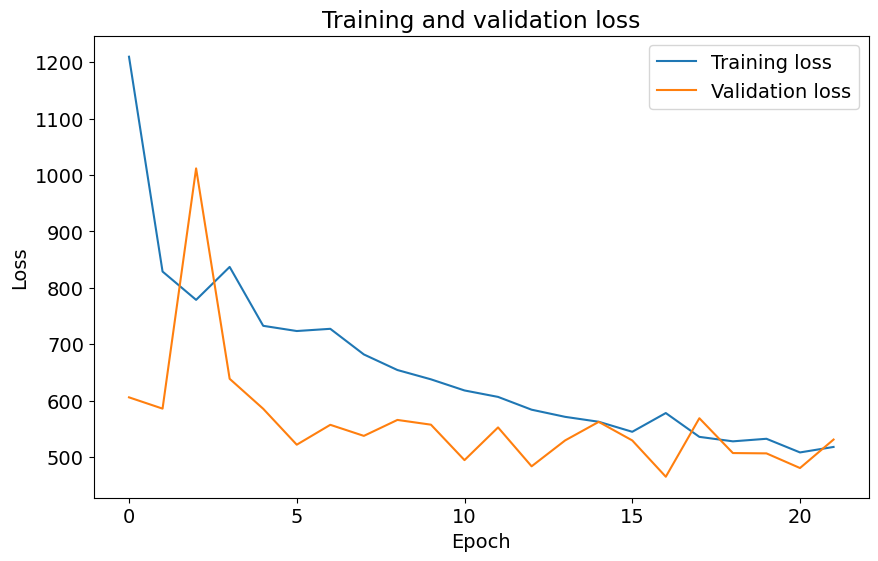

In [204]:
model44 = process_model(model44, X_train=X_train_num, X_valid=X_valid_num, X_test=X_test_num, epochs = 200)

In [205]:
model44a = build_baseline_model2(X_train_num.shape[1])

c:\Users\aisti\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Mean CRPS for baseline model with all predictors (except one-hot encoded holiday data): 342.76, loss function v2 used


Model information:

Callbacks: EarlyStopping (patience: 5), Learning Rate (Reduce on Plateau, patience: 5)
Batch size: 10
Epochs: 200

Epoch 1/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 1906.6339 - val_loss: 642.5812 - learning_rate: 0.0010
Epoch 2/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 730.9512 - val_loss: 1093.1503 - learning_rate: 0.0010
Epoch 3/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 738.9312 - val_loss: 788.7065 - learning_rate: 0.0010
Epoch 4/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 710.0452 - val_loss: 613.6420 - learning_rate: 0.0010
Epoch 5/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 706.7597 - val_loss: 768.2090 - learning_rate: 0.0010
Epoch 6/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 681.8629 - val_loss: 617.6119 - learning_rate: 0.0010
Epoch 7/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 657.4919 - val_loss: 587.5306 - learning_rate: 0.0010
Epoch 8/200
317/317 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - los

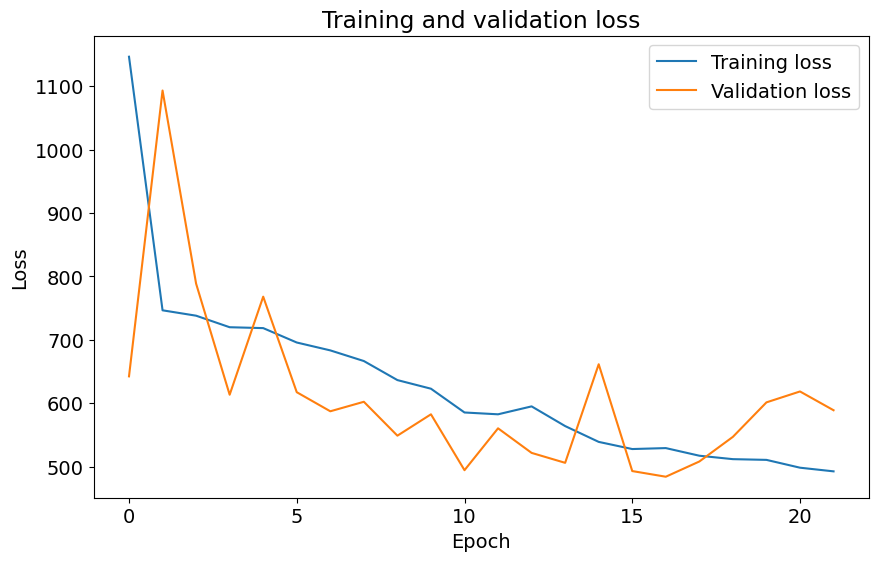

In [206]:
model44a = process_model(model44a, X_train=X_train_num, X_valid=X_valid_num, X_test=X_test_num, epochs = 200, loss_function=crps_normal_cost_function_v2)

In [207]:
X_train_num, X_valid_num, X_test_num = add_column(X_train_num, X_valid_num, X_test_num, X_train, X_valid, X_test, 'school_holiday_indicator')
X_train_num, X_valid_num, X_test_num = add_column(X_train_num, X_valid_num, X_test_num, X_train, X_valid, X_test, 'public_holiday_indicator')
X_train_num, X_valid_num, X_test_num = add_column(X_train_num, X_valid_num, X_test_num, X_train, X_valid, X_test, 'holiday_indicator')

In [208]:
X_train_num.head()

,temperature,humidity,visibility,precipitation,sun,precip_indic,is_workday,season,day_of_week,windspeed,wind_direction,windspeed_max,school_holiday_indicator,public_holiday_indicator,holiday_indicator
0,-0.039776,-0.645081,1.461434,-0.397192,-0.031329,0,1,0,2,-0.218119,0.079113,0.665623,0,0,0
1,0.244625,-0.607815,1.392951,-0.397192,-0.458165,0,1,0,3,-0.324284,1.042128,0.154228,0,0,0
2,0.381694,-0.417343,0.906360,-0.371451,0.254435,1,1,0,4,-1.076810,0.831722,-1.124262,0,0,0
3,1.300863,-1.551894,0.675680,-0.397192,1.357699,0,0,0,5,-0.405469,-0.349793,-0.357168,0,0,0
4,0.745990,-0.897664,1.407369,0.555250,0.059103,1,0,0,6,0.297096,0.532297,1.688415,0,0,0


In [209]:
X_train.columns

Index(['date', 'temperature', 'humidity', 'windspeed', 'wind_direction',
       'visibility', 'precipitation', 'sun', 'windspeed_max', 'precip_indic',
       'school_holiday', 'school_holiday_indicator', 'public_holiday',
       'public_holiday_indicator', 'holiday_indicator', 'is_workday', 'season',
       'day_of_week'],
      dtype='object')